In [1]:
!pip install scanpy
import torch; torch.manual_seed(100)
import torch.nn as nn
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import math
import numpy as np
import pandas as pd
import anndata as ad
np.random.seed(100)
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import scanpy as sc
from collections import OrderedDict
from collections import Counter

device = 'cpu'


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
PBMC_lupus = sc.read_h5ad("PBMC_lupus.h5ad")

In [4]:
print(PBMC_lupus) 
print(Counter(PBMC_lupus.obs["cell_type"])) 
print(Counter(PBMC_lupus.obs["condition"])) 

AnnData object with n_obs × n_vars = 13515 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'
Counter({'CD4T': 4452, 'FCGR3A+Mono': 2881, 'CD14+Mono': 2049, 'B': 1448, 'NK': 931, 'CD8T': 892, 'Dendritic': 862})
Counter({'stimulated': 7109, 'control': 6406})


In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout, z_dropout): 
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout))  


        self.mu = nn.Sequential(nn.Linear(800, latent_dims),
                                nn.Dropout(p = z_dropout))

        self.sigma = nn.Sequential(nn.Linear(800, latent_dims),
                                   nn.Dropout(p = z_dropout))

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = self.encoder(x)
        mu =  self.mu(x)
        sigma = torch.exp(self.sigma(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 1/2).sum() 

        return z


In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(nn.Linear(latent_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, input_dims)
                                     )

    def forward(self, z):
        z = self.decoder(z)
        return z

In [15]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, input_dims,dropout = 0.3, z_dropout=0.3):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout)
        self.decoder = Decoder(latent_dims, input_dims, dropout)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(vae, data, epochs=50, beta = 0.001, learning_rate = 0.0001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate) 
    losses = []
    klds = []
    mses = []
    vae.train() 
    
    for epoch in range(epochs):
        loss_e = 0
        kld_e = 0
        mse_e = 0

        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            mse = ((x - x_hat)**2).sum()
            kld = beta* vae.encoder.kl
            loss = mse +  kld # loss calculation
            loss.backward()
            opt.step()
            loss_e += loss.to('cpu').detach().numpy()
            kld_e += kld.to('cpu').detach().numpy()
            mse_e += mse.to('cpu').detach().numpy()

        losses.append(loss_e/(len(data)*128))
        klds.append(kld_e/(len(data)*128))
        mses.append(mse_e/(len(data)*128))

        print("epoch: ", epoch, " loss: ", loss_e/(len(data)*128))

    return vae, losses, klds, mses

In [9]:
PBMC_lupusX = torch.utils.data.DataLoader(PBMC_lupus.X.toarray(), batch_size=128) 
latent_dims = 50 

In [10]:
vae = VariationalAutoencoder(latent_dims = latent_dims, input_dims = PBMC_lupus.shape[1]).to(device)
vae, losses, klds, mses = train(vae, PBMC_lupusX, beta = 0.001) 

epoch:  0  loss:  468.03583
epoch:  1  loss:  334.7193
epoch:  2  loss:  294.70804
epoch:  3  loss:  269.50815
epoch:  4  loss:  250.25906
epoch:  5  loss:  235.72
epoch:  6  loss:  225.35043
epoch:  7  loss:  216.67761
epoch:  8  loss:  208.997
epoch:  9  loss:  201.77052
epoch:  10  loss:  198.54234
epoch:  11  loss:  195.25957
epoch:  12  loss:  191.41893
epoch:  13  loss:  188.23799
epoch:  14  loss:  187.1742
epoch:  15  loss:  186.12207
epoch:  16  loss:  185.90057
epoch:  17  loss:  184.16965
epoch:  18  loss:  182.23897
epoch:  19  loss:  181.29544
epoch:  20  loss:  181.04396
epoch:  21  loss:  180.01518
epoch:  22  loss:  179.43185
epoch:  23  loss:  178.12369
epoch:  24  loss:  177.7921
epoch:  25  loss:  177.78072
epoch:  26  loss:  177.21597
epoch:  27  loss:  176.51364
epoch:  28  loss:  175.99947
epoch:  29  loss:  175.84633
epoch:  30  loss:  175.9006
epoch:  31  loss:  175.926
epoch:  32  loss:  175.76787
epoch:  33  loss:  174.57053
epoch:  34  loss:  174.76506
epoch:

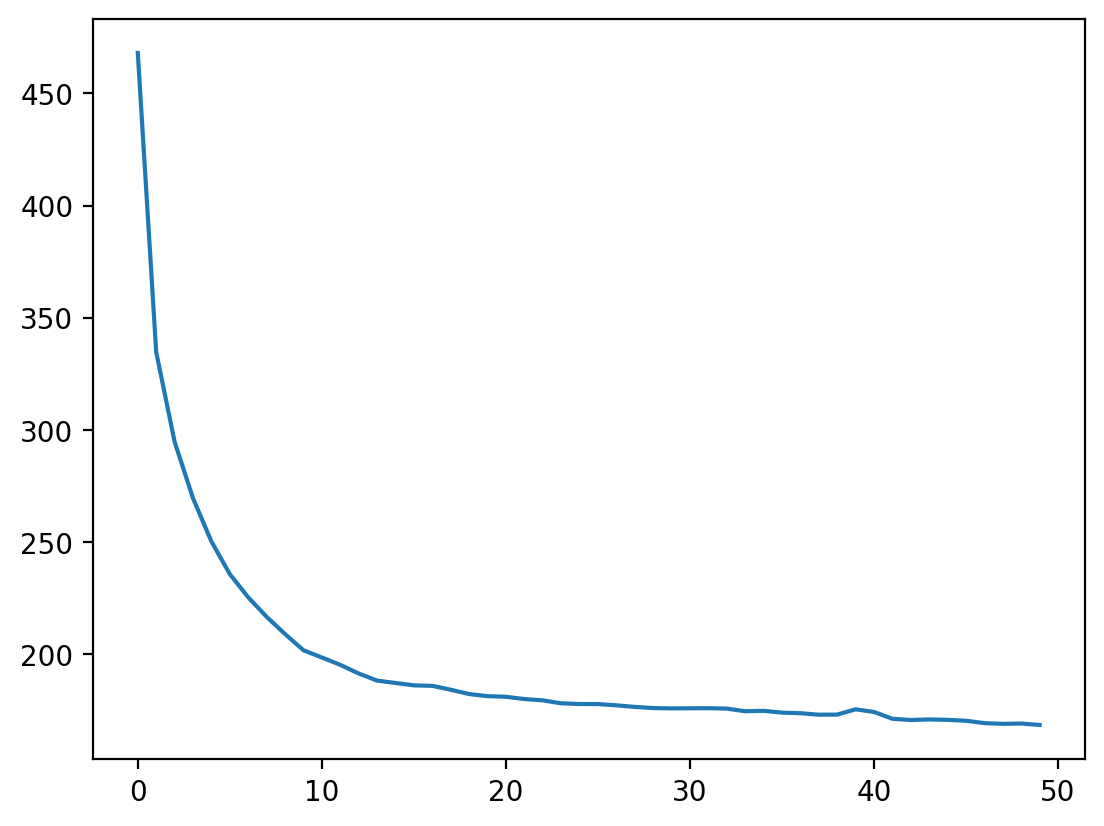

In [11]:
plt.plot(losses)

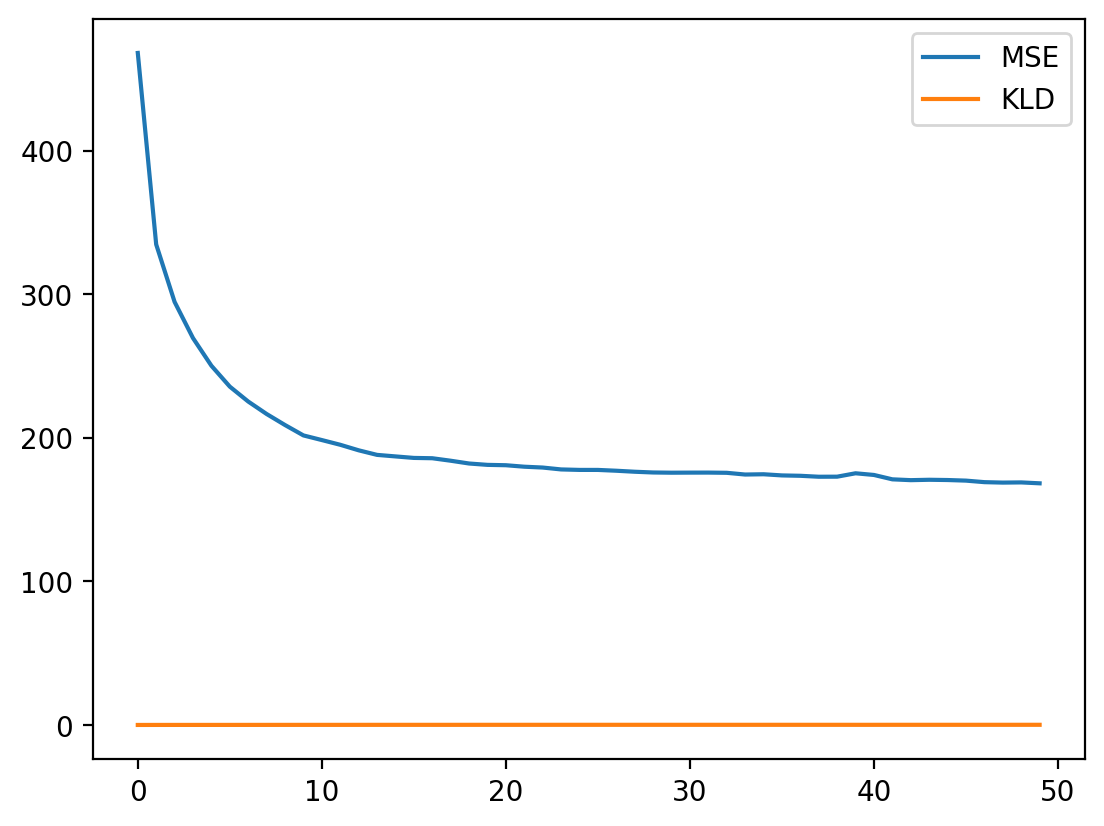

In [12]:
plt.plot(mses, label = "MSE")
plt.plot(klds, label = "KLD")
plt.legend()

In [22]:
def to_latent(vae, adata):
        latent = []
        data = torch.tensor(adata.X.toarray()).to(device)
        vae.eval() 
        z = vae.encoder(data)
        latent += [z.to("cpu")]
        return torch.cat(latent).detach().numpy()

In [23]:
PBMC_lupus.obsm["latent_embedding"] = to_latent(vae, PBMC_lupus)

NameError: name 'vae' is not defined

C:\Users\Zuzia\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


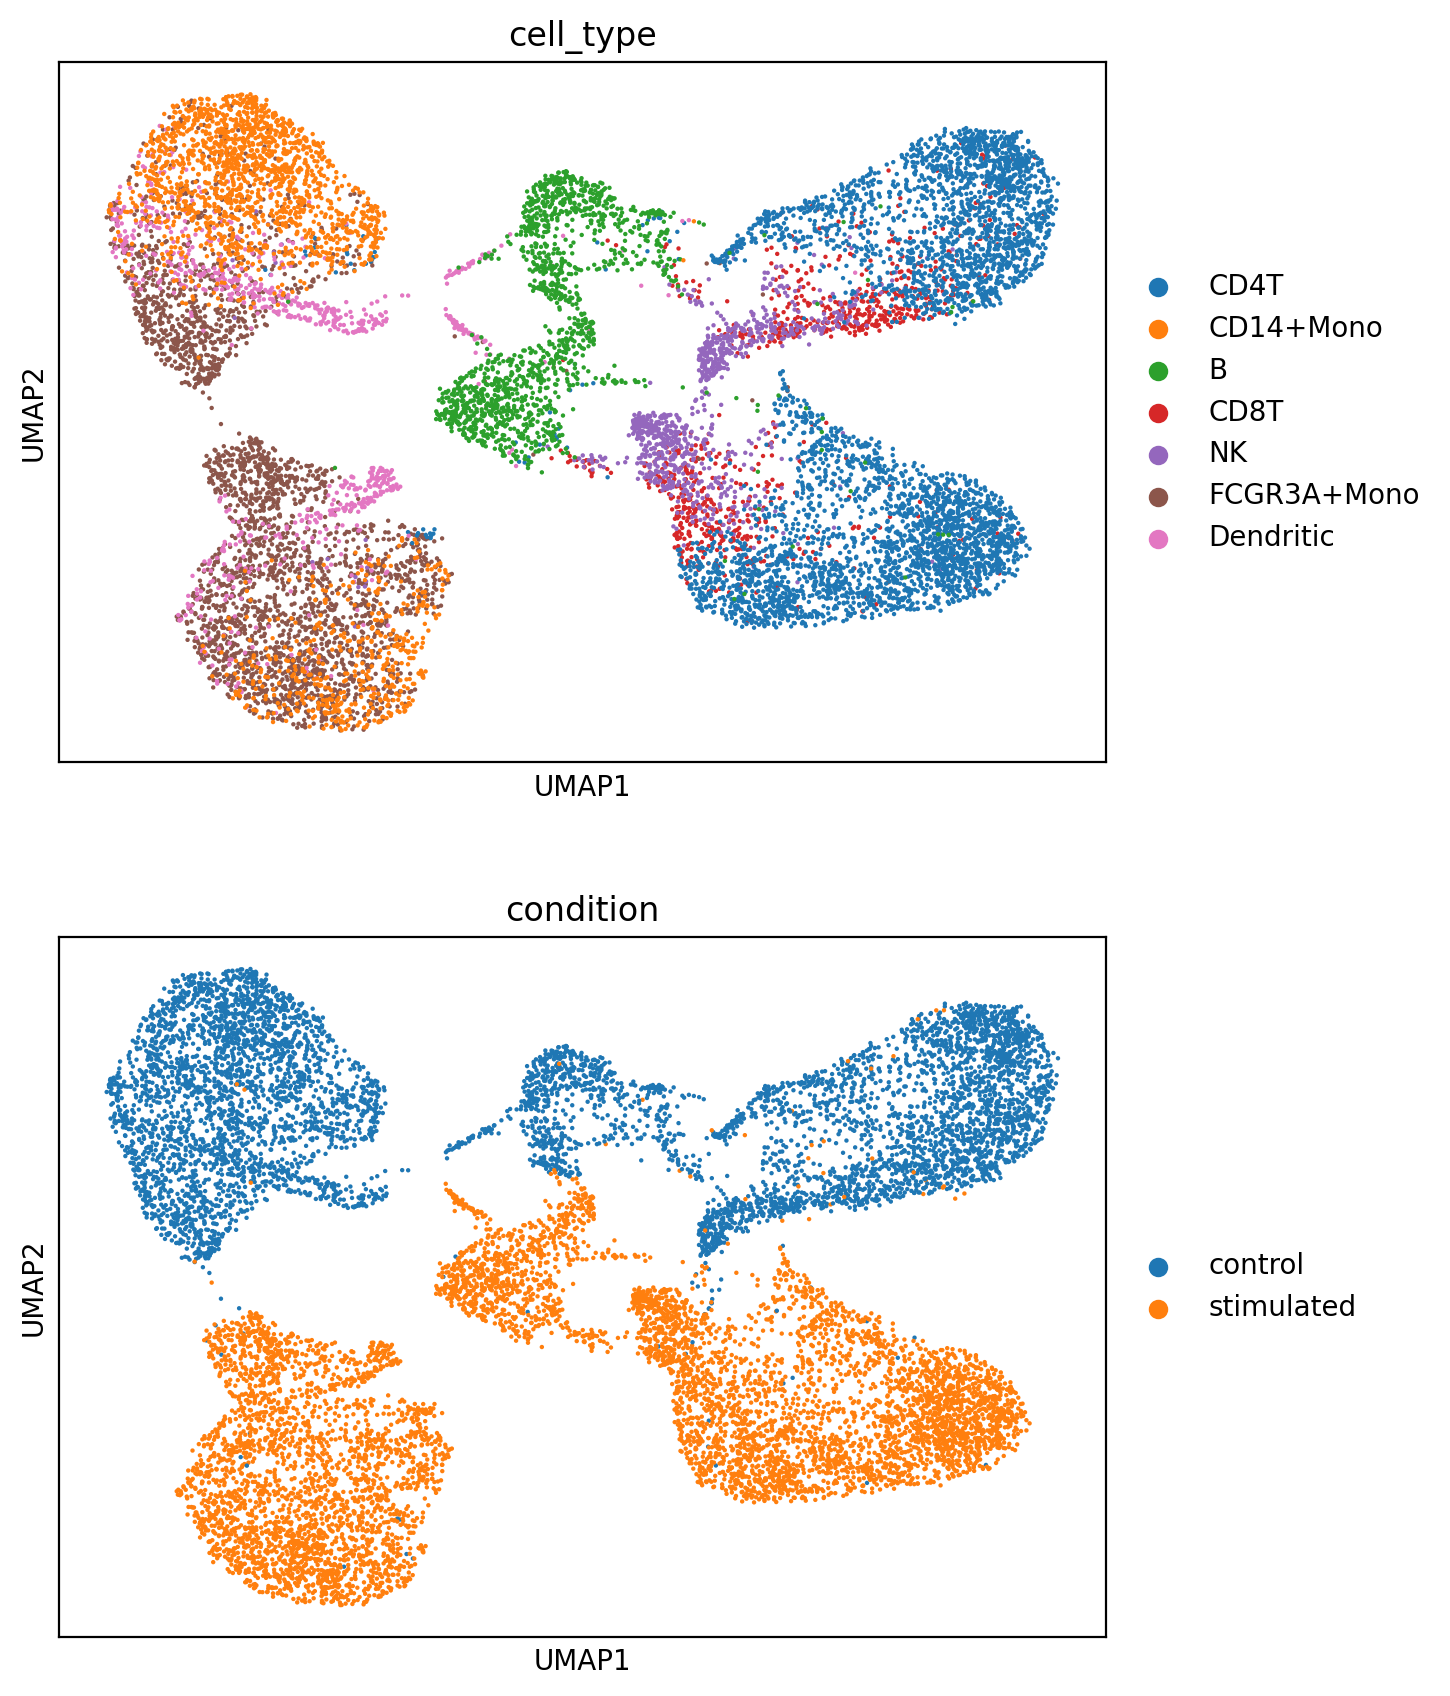

In [16]:
sc.pp.neighbors(PBMC_lupus, use_rep='latent_embedding', n_neighbors=15) 
sc.tl.umap(PBMC_lupus, random_state=13) 
sc.pl.umap(PBMC_lupus, color=["cell_type", "condition"], size=10, ncols = 1, save="_celltype_condition.png")

In [ ]:
with open('reactomes.gmt') as gmt_file: # first lines of the gmt file
    gmt_head = gmt_file.readlines()[0:10]
    for row in gmt_head:
      print(row)

REACTOME_GLYCOGEN_BREAKDOWN_GLYCOGENOLYSIS	http://www.broadinstitute.org/gsea/msigdb/cards/REACTOME_GLYCOGEN_BREAKDOWN_GLYCOGENOLYSIS	AGL	GYG1	PGM1	PHKA1	PHKA2	PHKB	PHKG1	PHKG2	PGM2	PYGB	PYGL	PYGM	PHKA1P1	LOC650556	CALM1	CALM2	CALM3	GYG2

REACTOME_TRANSLATION	http://www.broadinstitute.org/gsea/msigdb/cards/REACTOME_TRANSLATION	SEC61B	RPL35	EEF1DP1	RPL7AP27	DDOST	EEF1A1	EEF1B2	EEF1D	EEF1G	EEF2	EIF1AX	EIF2S1	EIF2B1	EIF2S3	EIF4A1	EIF4A2	EIF4B	EIF4E	EIF4EBP1	EIF4G1	EIF5	ETF1	FAU	TRAM1	SEC11A	SEC61G	RPL13A	GSPT2	RPL36	PABPC1	EIF3K	RPL10P16	FAM153A	SPCS1	SEC61A1	EIF3FP3	RPL36P14	EIF3E	RPSAP12	RPS8P10	RPL7AP66	RPL10P9	RPS12P4	RPSA	RPS26P10	RPL23AP2	RPS12P22	RPL21P29	RPS26P35	RPL10A	RPL26L1	SEC61A2	SRPRB	SPCS3	RPL3	RPL3L	RPL4	RPL5	RPL6	RPL7	RPL7A	RPL8	RPL9	RPL10	RPL11	RPL12	RPL13	RPL15	RPL17	RPL18	RPL18A	RPL19	RPL21	RPL22	RPL23A	RPL24	RPL26	RPL27	RPL30	RPL27A	RPL28	RPL29	RPL31	RPL32	RPL34	RPL35A	RPL37	RPL37A	RPL38	RPL39	RPL41	RPL36A	RPLP0	RPLP1	RPLP2	RPN1	RPN2	RPS2	RPS3	RPS3A	RPS4X	RPS4Y1	RPS5

In [ ]:
####### Adapted code from https://github.com/LucasESBS/vega ######

def create_mask(adata, gmt_path:str=None, add_nodes:int=1, sep = "\t"):

    gmv_dict = OrderedDict()
    with open(gmt_path) as f:
        for line in f.readlines():
            line = line.strip()
            spli = line.split(sep)
            gmv_dict[spli[0]] = spli[2:]

    feature_list = adata.var.index.tolist()


    # Mask
    mask = np.zeros((len(feature_list), len(gmv_dict)))
    for j, k in enumerate(gmv_dict.keys()):
        for i in range(mask.shape[0]):
            if feature_list[i] in gmv_dict[k]:
                mask[i,j] = 1.
    
    vec = np.ones((mask.shape[0], add_nodes))
    mask = np.hstack((mask, vec))

    adata.uns['_vega'] = dict() 
    adata.uns['_vega']['mask'] = mask
    adata.uns['_vega']['gmv_names'] = list(gmv_dict.keys()) + ['UNANNOTATED_'+str(k) for k in range(add_nodes)]

    return adata, mask

In [ ]:
PBMC_lupus, mask = create_mask(PBMC_lupus, gmt_path= "reactomes.gmt", add_nodes=1)

In [20]:
print(mask)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
class DecoderVEGA(nn.Module):

  def __init__(self,
               mask):
        super(DecoderVEGA, self).__init__()

        self.sparse_layer = nn.Sequential(SparseLayer(mask)) 

  def forward(self, x):
    z = self.sparse_layer(x.to(device))
    return(z)

  def positive_weights(self):
      w = self.sparse_layer[0].weight
      w.data = w.data.clamp(0)
      return w


class SparseLayer(nn.Module):
  def __init__(self, mask):

        super(SparseLayer, self).__init__()

        self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False)
        self.weight = nn.Parameter(torch.Tensor(mask.shape[1], mask.shape[0]))
        self.bias = nn.Parameter(torch.Tensor(mask.shape[1]))
        self.reset_parameters()

        # mask weight
        self.weight.data = self.weight.data * self.mask

  def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input):
        return SparseLayerFunction.apply(input, self.weight, self.bias, self.mask)


class SparseLayerFunction(torch.autograd.Function):
    # Both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input, weight, bias, mask):

        weight = weight * mask 
        output = input.mm(weight.t())
        output += bias.unsqueeze(0).expand_as(output)
        ctx.save_for_backward(input, weight, bias, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output): 
        input, weight, bias, mask = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = grad_mask = None

        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
            grad_weight = grad_weight * mask
        if ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias, grad_mask


In [ ]:
class VEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3):
        super(VEGA, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) 
        self.decoder = DecoderVEGA(mask)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
#training loop
def trainVEGA(vae, data, epochs=100, beta = 0.0001, learning_rate = 0.001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    vae.train() 
    losses = []
    klds = []
    mses = []

    for epoch in range(epochs):
        loss_e = 0
        kld_e = 0
        mse_e = 0

        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            mse = ((x - x_hat)**2).sum()
            kld = beta* vae.encoder.kl
            loss = mse +  kld # loss calculation
            loss.backward()
            opt.step()
            loss_e += loss.to('cpu').detach().numpy()
            kld_e += kld.to('cpu').detach().numpy()
            mse_e += mse.to('cpu').detach().numpy()
            vae.decoder.positive_weights() 

        losses.append(loss_e/(len(data)*128))
        klds.append(kld_e/(len(data)*128))
        mses.append(mse_e/(len(data)*128))

        print("epoch: ", epoch, " loss: ", loss_e/(len(data)*128))

    return vae, losses, klds, mses

In [24]:
vega = VEGA(latent_dims= mask.shape[1], input_dims = mask.shape[0], mask = mask.T, z_dropout = 0.5, dropout = 0.3).to(device)
# model training
vega, vega_losses, vega_klds, vega_mses = trainVEGA(vega, PBMC_lupusX,epochs = 100, beta = 0.0001)

epoch:  0  loss:  275.91022
epoch:  1  loss:  243.51936
epoch:  2  loss:  229.6137
epoch:  3  loss:  225.686
epoch:  4  loss:  223.20926
epoch:  5  loss:  215.58131
epoch:  6  loss:  211.9723
epoch:  7  loss:  209.17624
epoch:  8  loss:  207.48083
epoch:  9  loss:  205.42375
epoch:  10  loss:  203.92558
epoch:  11  loss:  202.1765
epoch:  12  loss:  201.82693
epoch:  13  loss:  200.1898
epoch:  14  loss:  200.13293
epoch:  15  loss:  198.99687
epoch:  16  loss:  197.94934
epoch:  17  loss:  197.45032
epoch:  18  loss:  198.17287
epoch:  19  loss:  200.19247
epoch:  20  loss:  199.47478
epoch:  21  loss:  195.75038
epoch:  22  loss:  194.39352
epoch:  23  loss:  195.20193
epoch:  24  loss:  193.1467
epoch:  25  loss:  193.21637
epoch:  26  loss:  193.91287
epoch:  27  loss:  192.89944
epoch:  28  loss:  191.71056
epoch:  29  loss:  190.60243
epoch:  30  loss:  190.401
epoch:  31  loss:  190.02866
epoch:  32  loss:  190.11548
epoch:  33  loss:  189.73784
epoch:  34  loss:  190.13766
epoc

In [25]:
torch.save(vega.state_dict(), "vega_model.pt")

In [ ]:

vega = VEGA(latent_dims=mask.shape[1], input_dims=mask.shape[0], mask=mask.T, z_dropout=0.5, dropout=0.3).to(device)

vega.load_state_dict(torch.load("vega_model.pt", map_location=device))
vega.eval()



VEGA(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=6998, out_features=800, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=800, out_features=800, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.3, inplace=False)
    )
    (mu): Sequential(
      (0): Linear(in_features=800, out_features=675, bias=True)
      (1): Dropout(p=0.5, inplace=False)
    )
    (sigma): Sequential(
      (0): Linear(in_features=800, out_features=675, bias=True)
      (1): Dropout(p=0.5, inplace=False)
    )
  )
  (decoder): DecoderVEGA(
    (sparse_layer): Sequential(
      (0): SparseLayer()
    )
  )
)

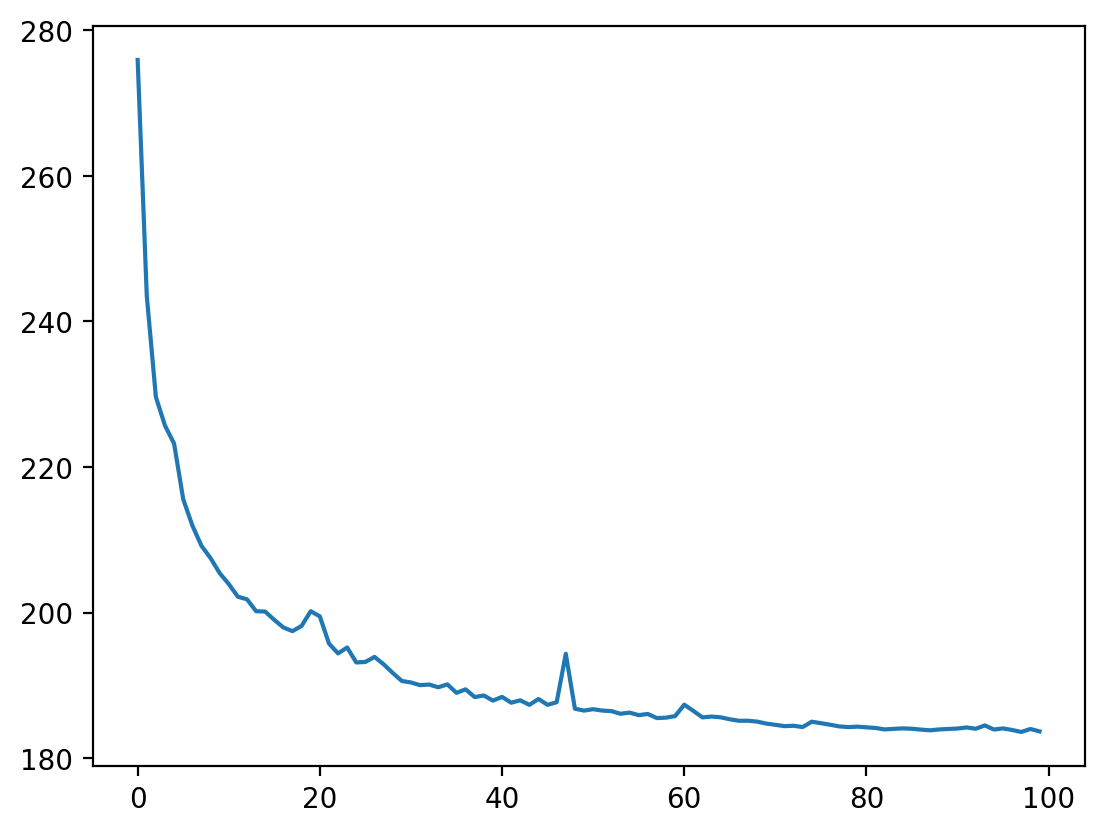

In [26]:
plt.plot(vega_losses)

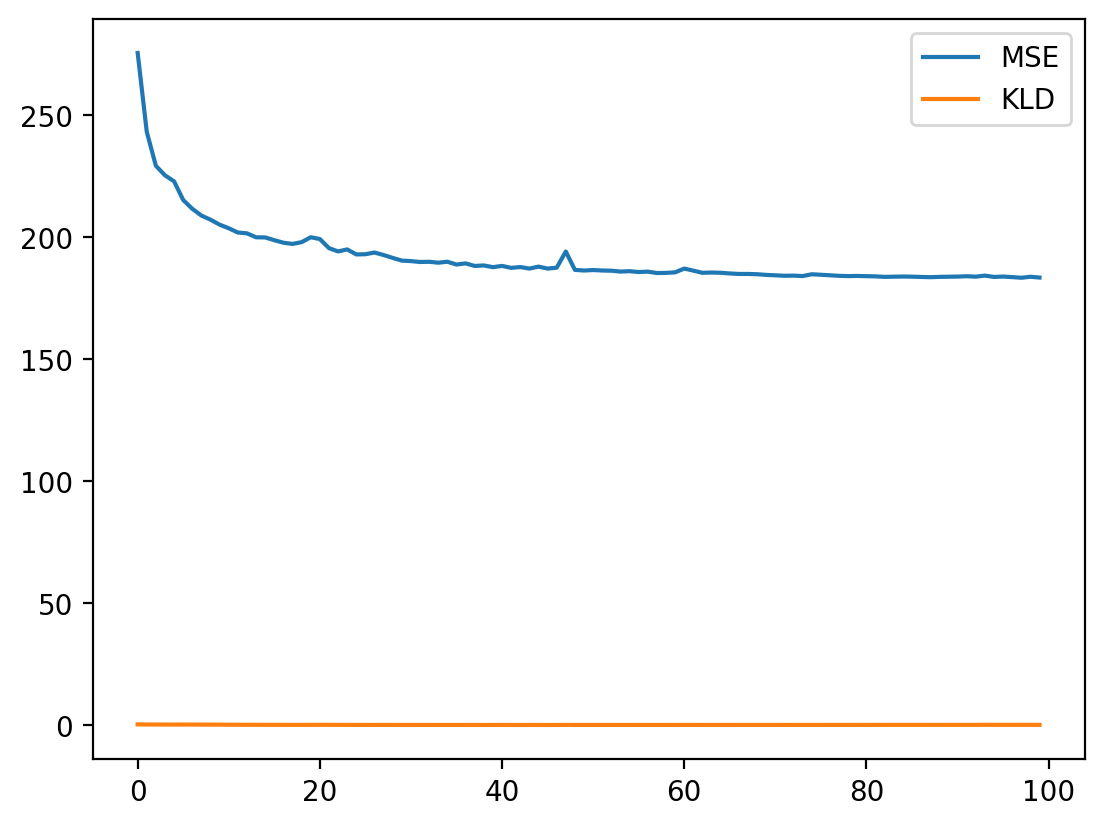

In [27]:
plt.plot(vega_mses, label = "MSE")
plt.plot(vega_klds, label = "KLD")
plt.legend()

In [26]:
print(torch.sum(vega.state_dict()["decoder.sparse_layer.0.weight"]<0))

tensor(0)


In [ ]:
PBMC_lupus.obsm["latent_embedding"] = to_latent(vega, PBMC_lupus) 

C:\Users\Zuzia\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


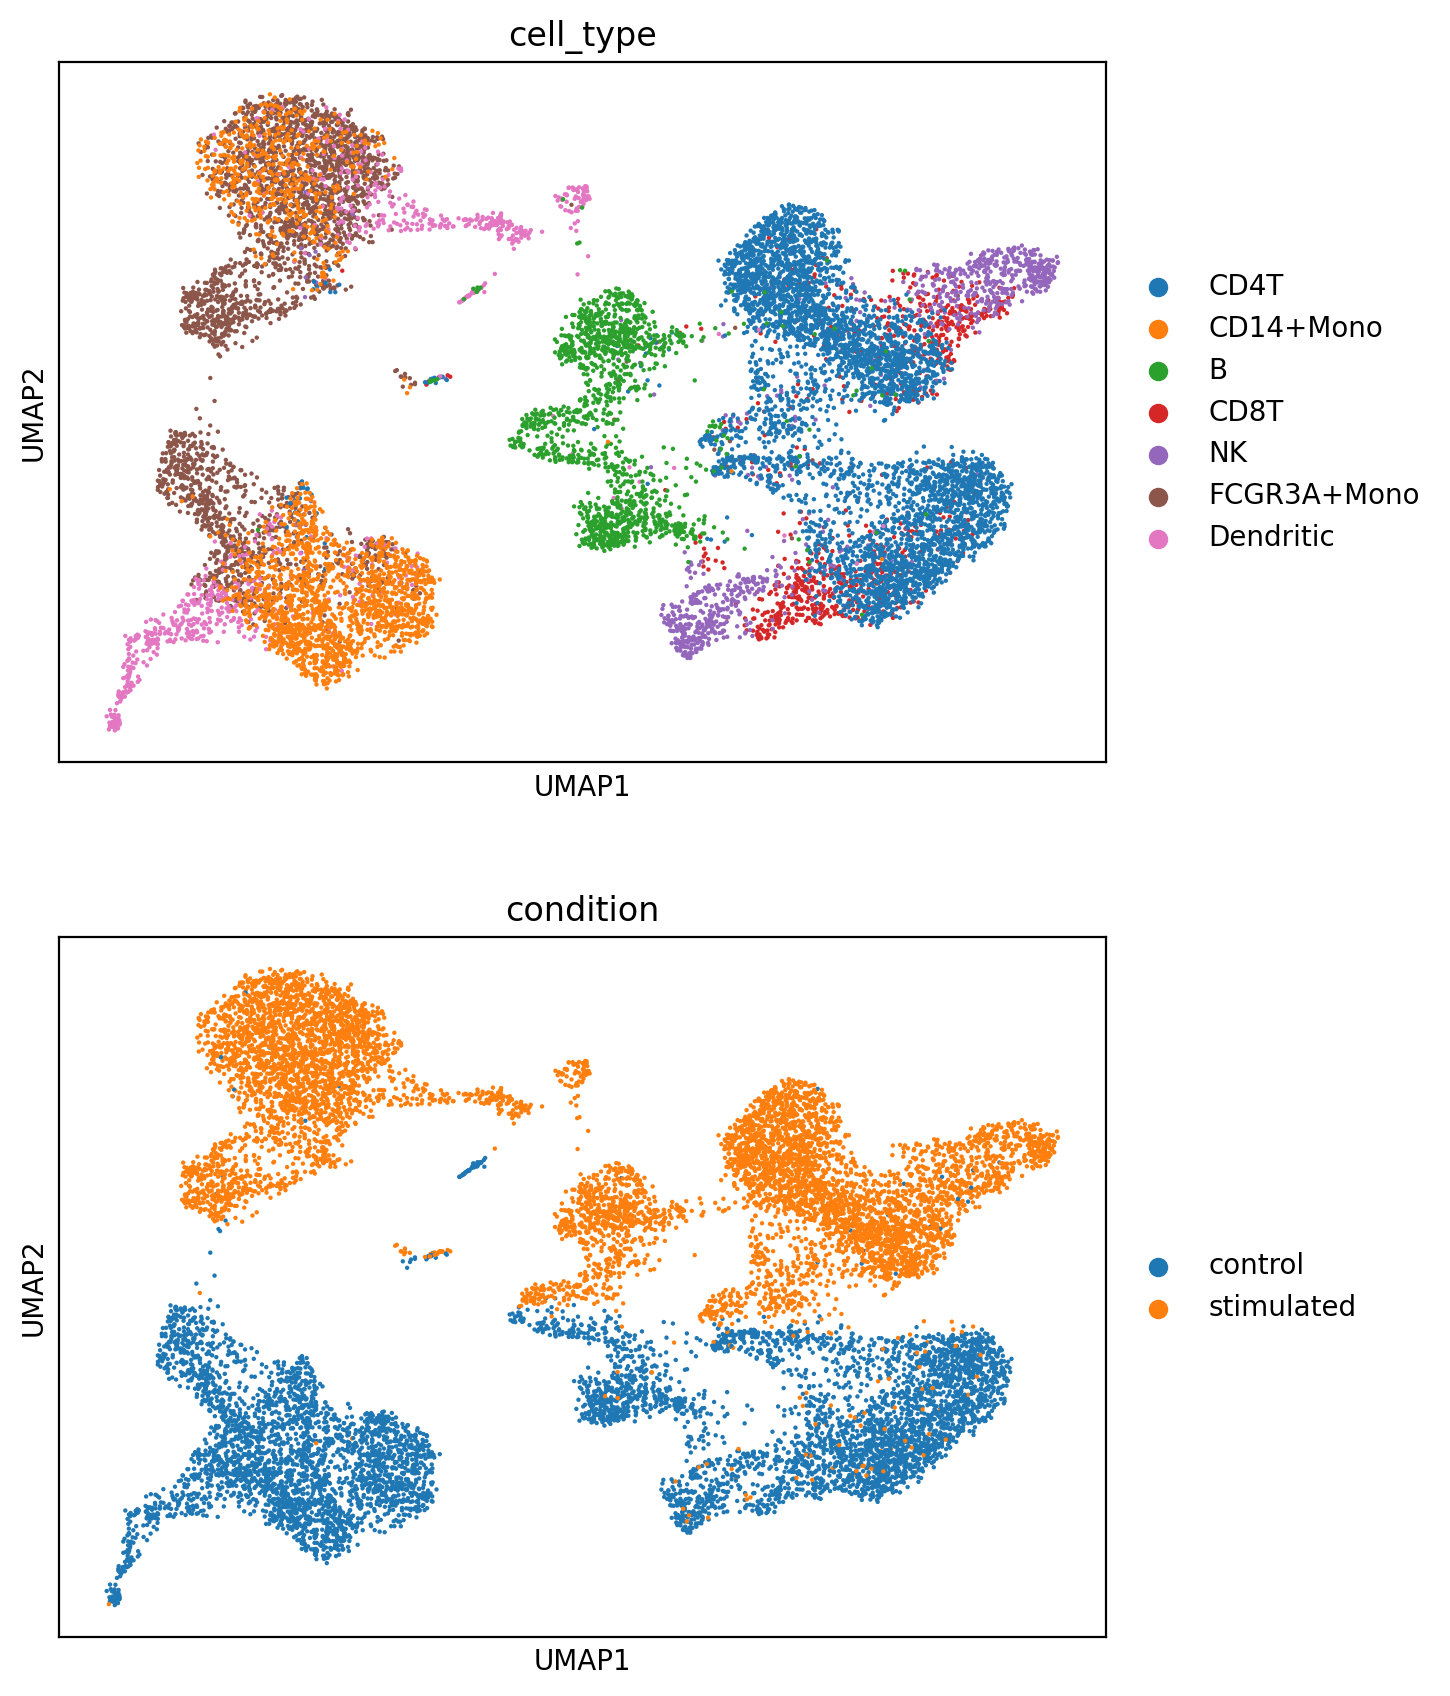

In [27]:
# UMAP based on the latent embedding
sc.pp.neighbors(PBMC_lupus, use_rep='latent_embedding', n_neighbors=15)
sc.tl.umap(PBMC_lupus, random_state=13)
sc.pl.umap(PBMC_lupus, color=["cell_type", "condition"], size=10, ncols = 1, save="_vega_celltype_condition.png")

In [ ]:
'''
REACTOME_NEF_MEDIATED_DOWNREGULATION_OF_MHC_CLASS_I_COMPLEX_CELL_SURFACE_EXPRESSION

REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION

REACTOME_CROSS_PRESENTATION_OF_SOLUBLE_EXOGENOUS_ANTIGENS_ENDOSOMES

REACTOME_IL_7_SIGNALING

REACTOME_GROWTH_HORMONE_RECEPTOR_SIGNALING

REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED_GENES

REACTOME_PROLACTIN_RECEPTOR_SIGNALING

REACTOME_SIGNALING_BY_SCF_KIT

REACTOME_SIGNALING_BY_ERBB4

REACTOME_SIGNALLING_BY_NGF (zawiera m.in. STAT3)

REACTOME_INTERFERON_ALPHA_BETA_SIGNALING
'''

'\nREACTOME_NEF_MEDIATED_DOWNREGULATION_OF_MHC_CLASS_I_COMPLEX_CELL_SURFACE_EXPRESSION\n\nREACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION\n\nREACTOME_CROSS_PRESENTATION_OF_SOLUBLE_EXOGENOUS_ANTIGENS_ENDOSOMES\n\nREACTOME_IL_7_SIGNALING\n\nREACTOME_GROWTH_HORMONE_RECEPTOR_SIGNALING\n\nREACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED_GENES\n\nREACTOME_PROLACTIN_RECEPTOR_SIGNALING\n\nREACTOME_SIGNALING_BY_SCF_KIT\n\nREACTOME_SIGNALING_BY_ERBB4\n\nREACTOME_SIGNALLING_BY_NGF (zawiera m.in. STAT3)\n\n\n'

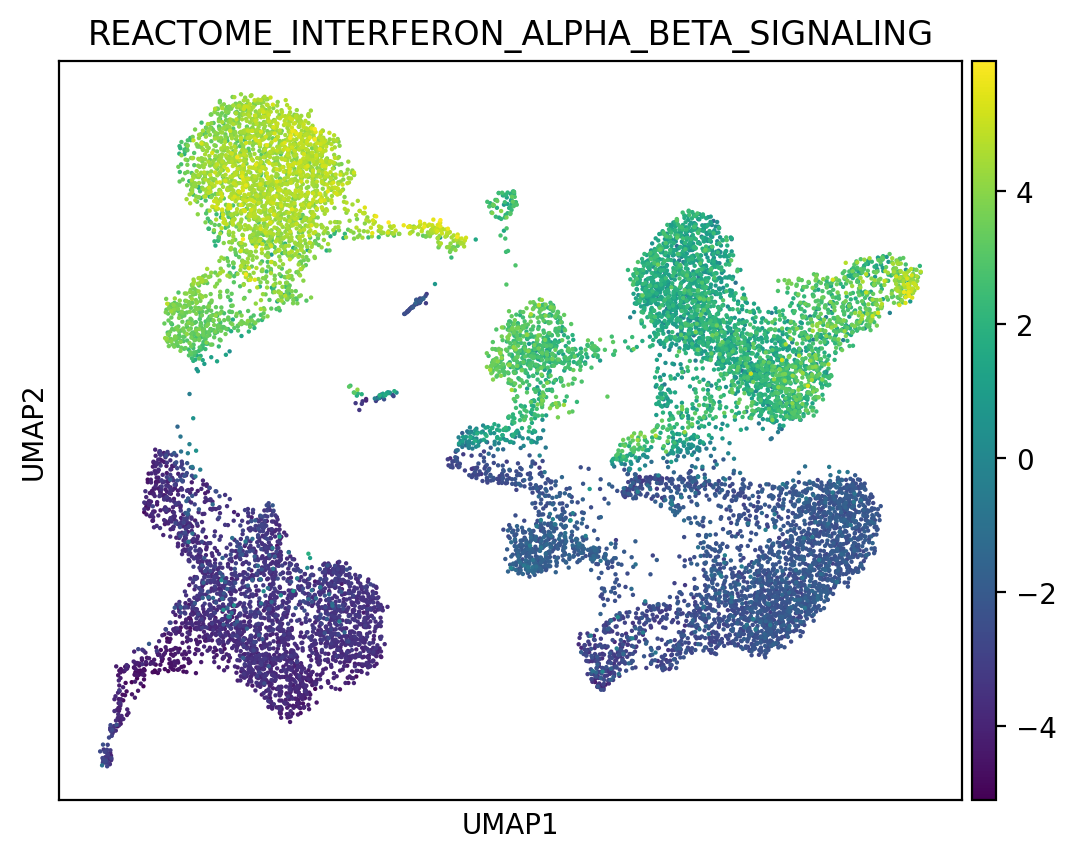

In [ ]:
pathway_of_interest = "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING"

pathways = PBMC_lupus.uns["_vega"]["gmv_names"] # the names of the GMVs are stored here
pw_activities = PBMC_lupus.obsm["latent_embedding"] # pathway activities 

PBMC_lupus.obs[pathway_of_interest] =  PBMC_lupus.obsm["latent_embedding"][:,pathways.index(pathway_of_interest)]
sc.pl.umap(PBMC_lupus, color=[pathway_of_interest], size=10, ncols = 1, save="_REACTOME_INTERFERON_ALPHA_BETA_SIGNALING.png")

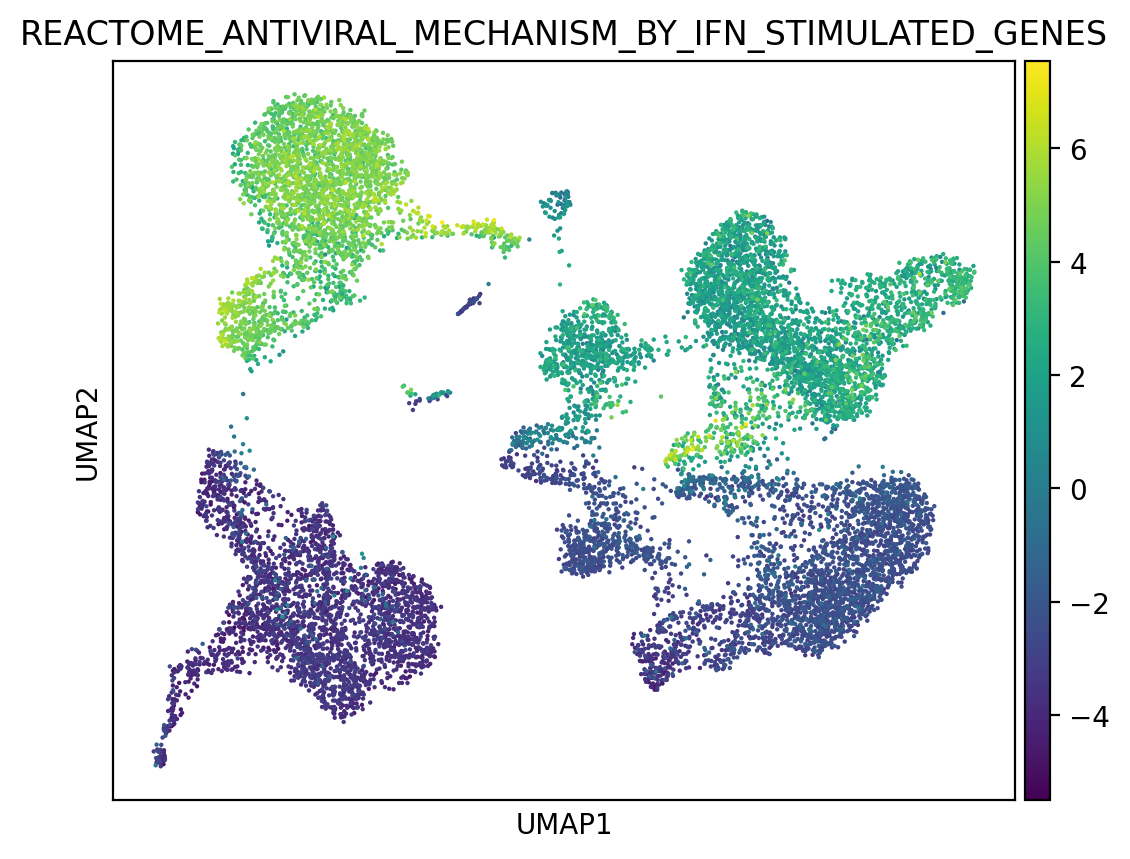

In [29]:
pathway_of_interest = "REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED_GENES"

pathways = PBMC_lupus.uns["_vega"]["gmv_names"] 
pw_activities = PBMC_lupus.obsm["latent_embedding"] 

PBMC_lupus.obs[pathway_of_interest] =  PBMC_lupus.obsm["latent_embedding"][:,pathways.index(pathway_of_interest)]
sc.pl.umap(PBMC_lupus, color=[pathway_of_interest], size=10, ncols = 1, save="_REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED_GENES.png")

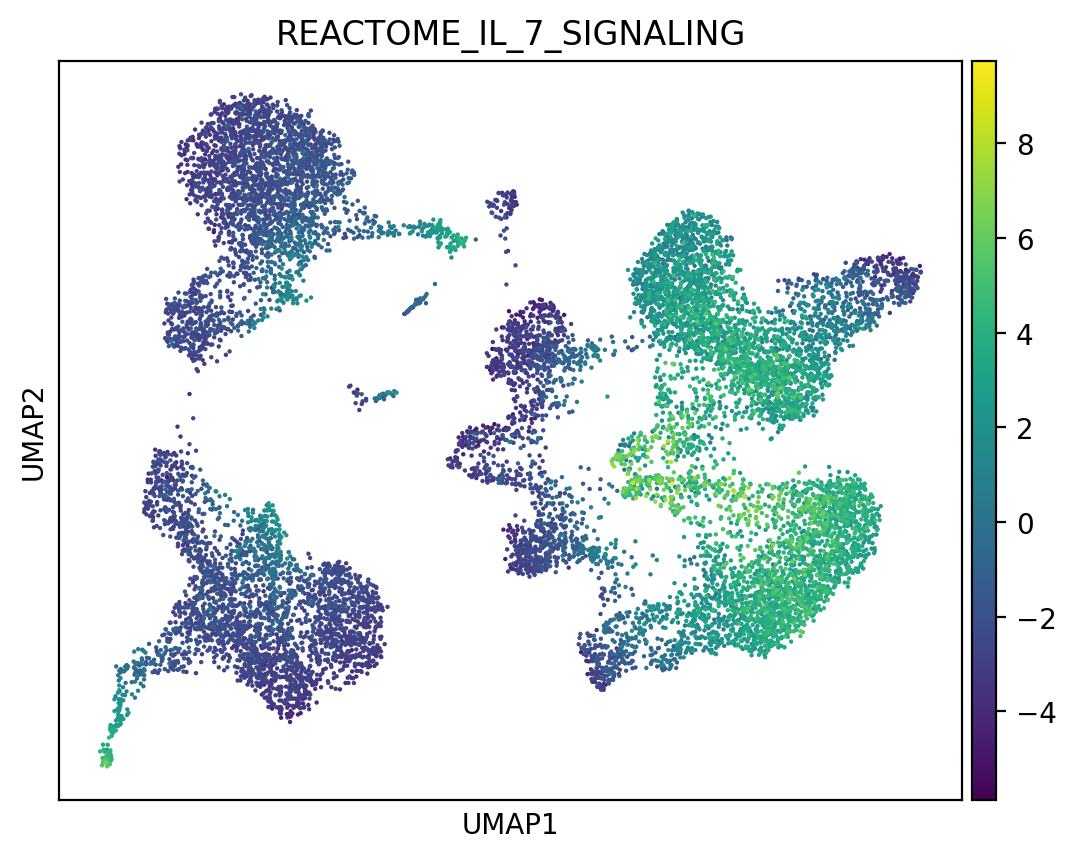

In [30]:
pathway_of_interest = "REACTOME_IL_7_SIGNALING"

pathways = PBMC_lupus.uns["_vega"]["gmv_names"] 
pw_activities = PBMC_lupus.obsm["latent_embedding"] 

PBMC_lupus.obs[pathway_of_interest] =  PBMC_lupus.obsm["latent_embedding"][:,pathways.index(pathway_of_interest)]
sc.pl.umap(PBMC_lupus, color=[pathway_of_interest], size=10, ncols = 1, save="_REACTOME_IL_7_SIGNALING.png")

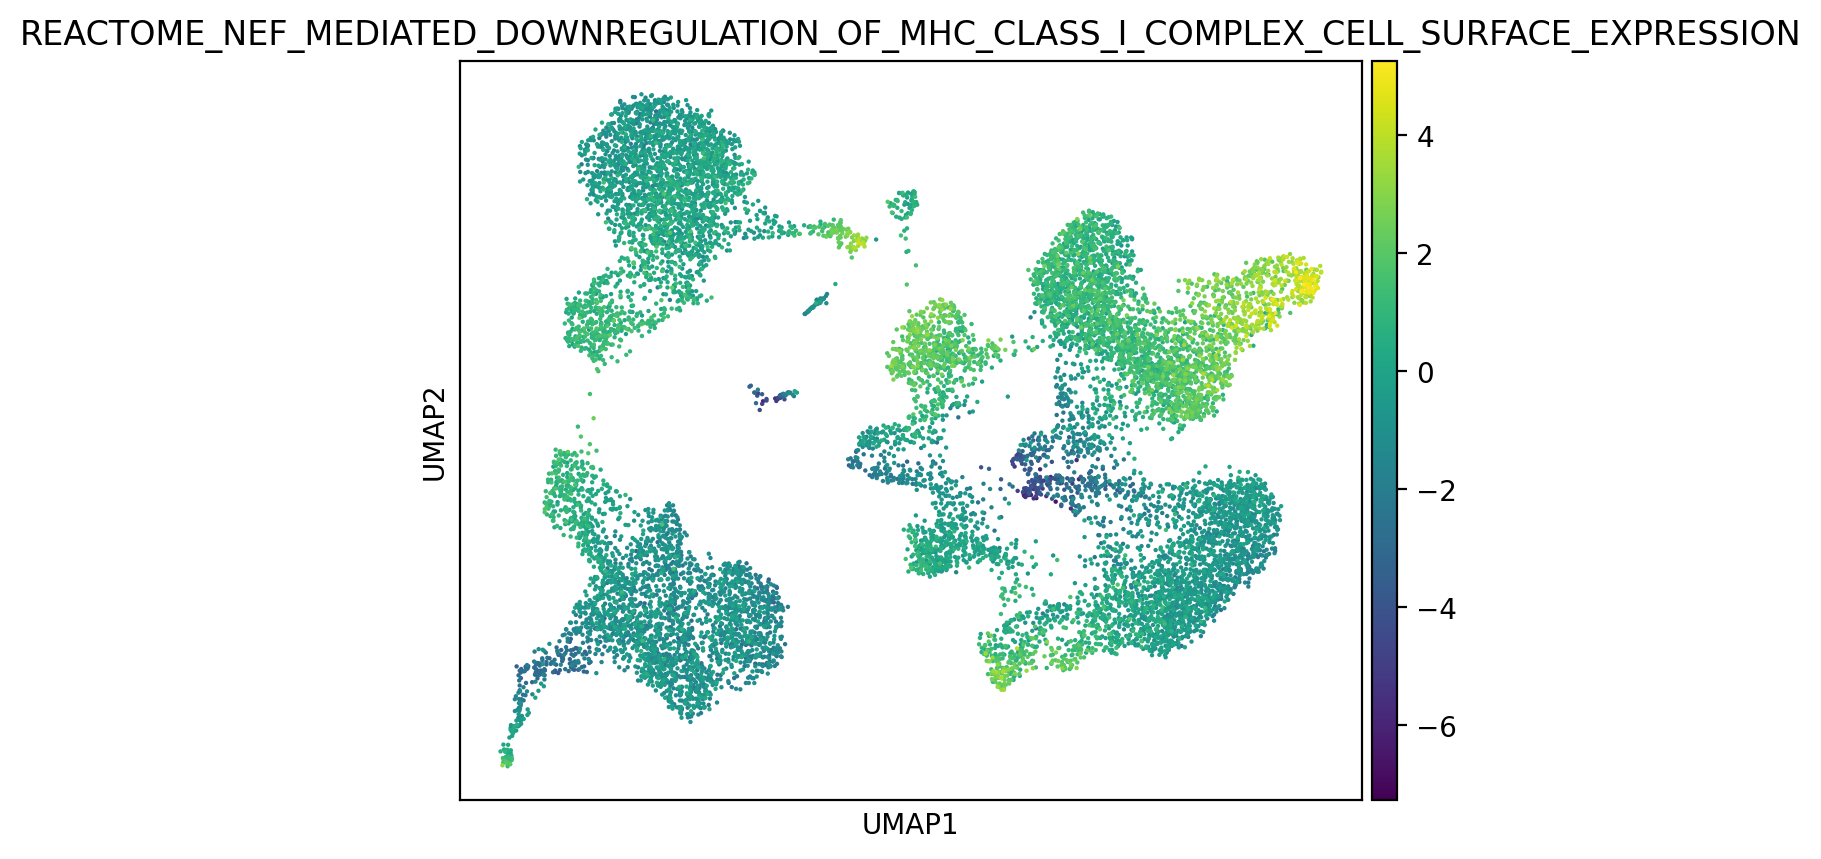

In [31]:
pathway_of_interest = "REACTOME_NEF_MEDIATED_DOWNREGULATION_OF_MHC_CLASS_I_COMPLEX_CELL_SURFACE_EXPRESSION"

pathways = PBMC_lupus.uns["_vega"]["gmv_names"] 
pw_activities = PBMC_lupus.obsm["latent_embedding"] 

PBMC_lupus.obs[pathway_of_interest] =  PBMC_lupus.obsm["latent_embedding"][:,pathways.index(pathway_of_interest)]
sc.pl.umap(PBMC_lupus, color=[pathway_of_interest], size=10, ncols = 1, save="_REACTOME_NEF_MEDIATED_DOWNREGULATION_OF_MHC_CLASS_I_COMPLEX_CELL_SURFACE_EXPRESSION.png")

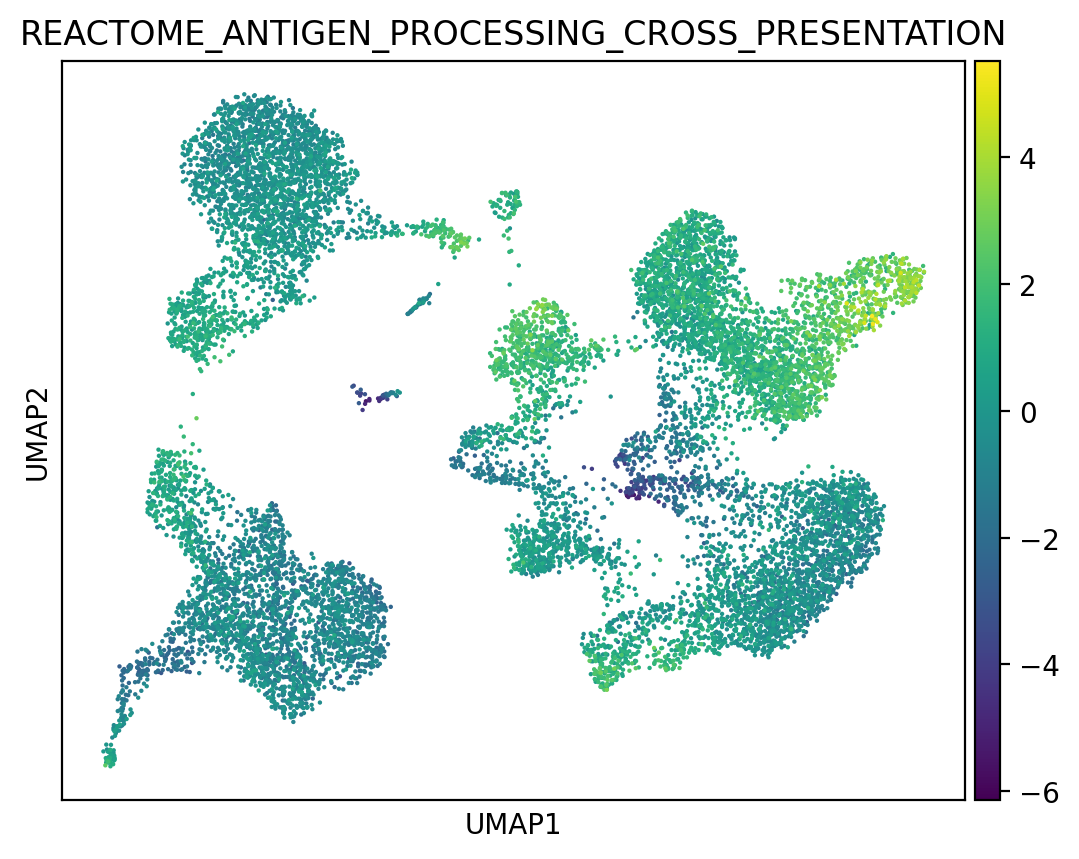

In [32]:
pathway_of_interest = "REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION"

pathways = PBMC_lupus.uns["_vega"]["gmv_names"] 
pw_activities = PBMC_lupus.obsm["latent_embedding"] 

PBMC_lupus.obs[pathway_of_interest] =  PBMC_lupus.obsm["latent_embedding"][:,pathways.index(pathway_of_interest)]
sc.pl.umap(PBMC_lupus, color=[pathway_of_interest], size=10, ncols = 1, save="_REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION.png")

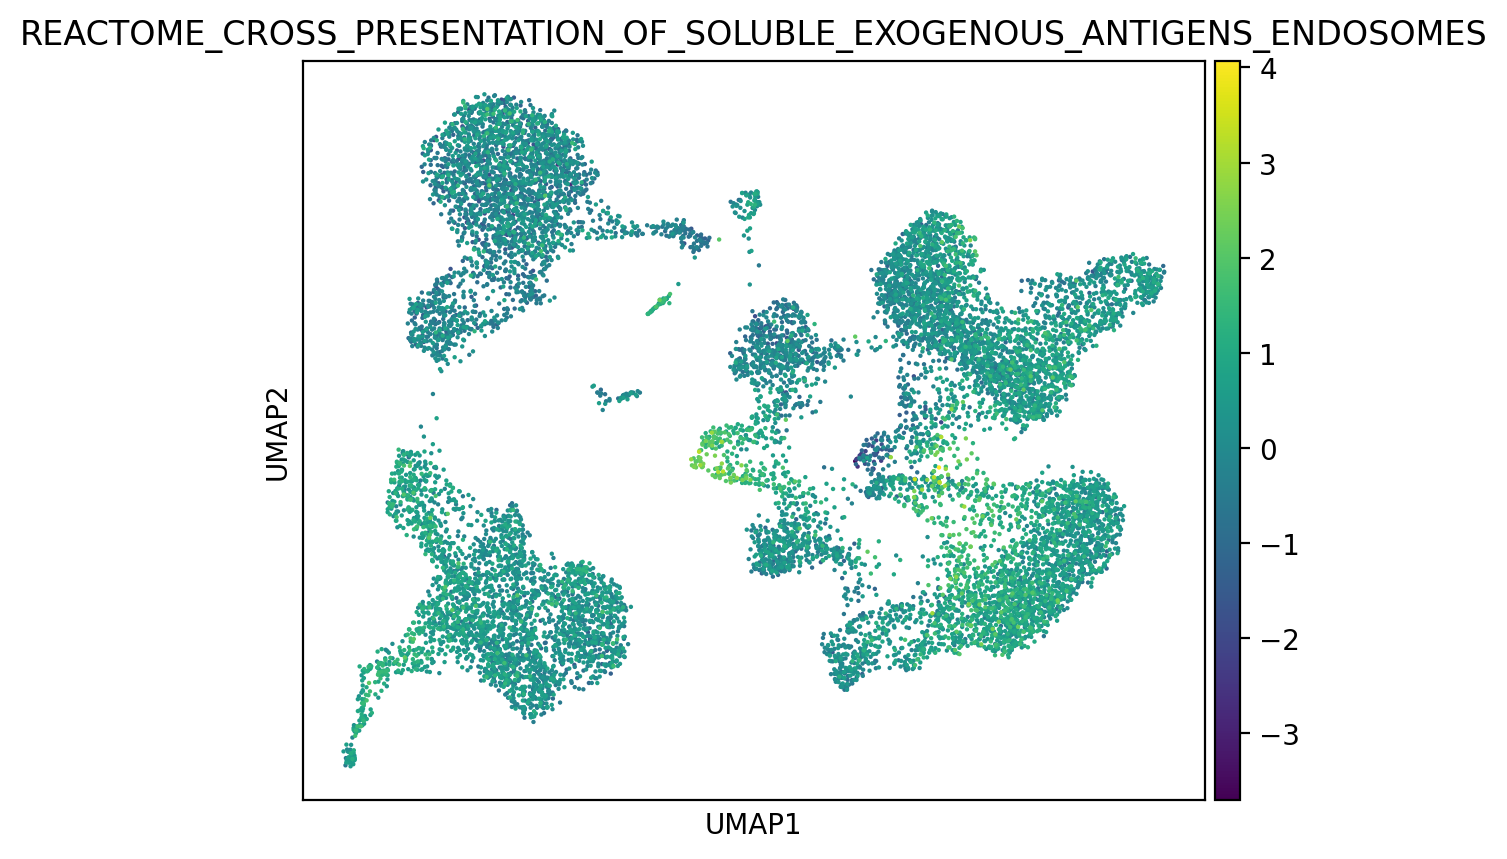

In [33]:
pathway_of_interest = "REACTOME_CROSS_PRESENTATION_OF_SOLUBLE_EXOGENOUS_ANTIGENS_ENDOSOMES"

pathways = PBMC_lupus.uns["_vega"]["gmv_names"] 
pw_activities = PBMC_lupus.obsm["latent_embedding"] 

PBMC_lupus.obs[pathway_of_interest] =  PBMC_lupus.obsm["latent_embedding"][:,pathways.index(pathway_of_interest)]
sc.pl.umap(PBMC_lupus, color=[pathway_of_interest], size=10, ncols = 1, save="_REACTOME_CROSS_PRESENTATION_OF_SOLUBLE_EXOGENOUS_ANTIGENS_ENDOSOMES.png")

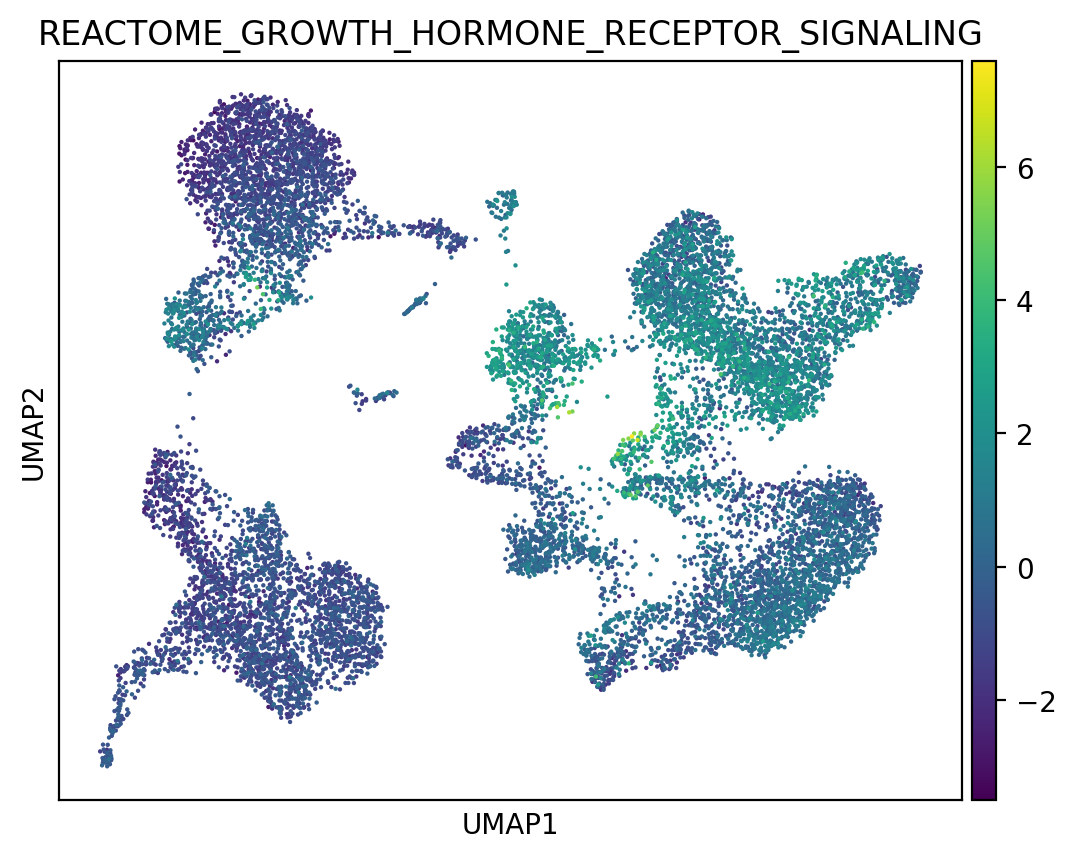

In [34]:
pathway_of_interest = "REACTOME_GROWTH_HORMONE_RECEPTOR_SIGNALING"

pathways = PBMC_lupus.uns["_vega"]["gmv_names"] 
pw_activities = PBMC_lupus.obsm["latent_embedding"] 

PBMC_lupus.obs[pathway_of_interest] =  PBMC_lupus.obsm["latent_embedding"][:,pathways.index(pathway_of_interest)]
sc.pl.umap(PBMC_lupus, color=[pathway_of_interest], size=10, ncols = 1, save="_REACTOME_GROWTH_HORMONE_RECEPTOR_SIGNALING.png")

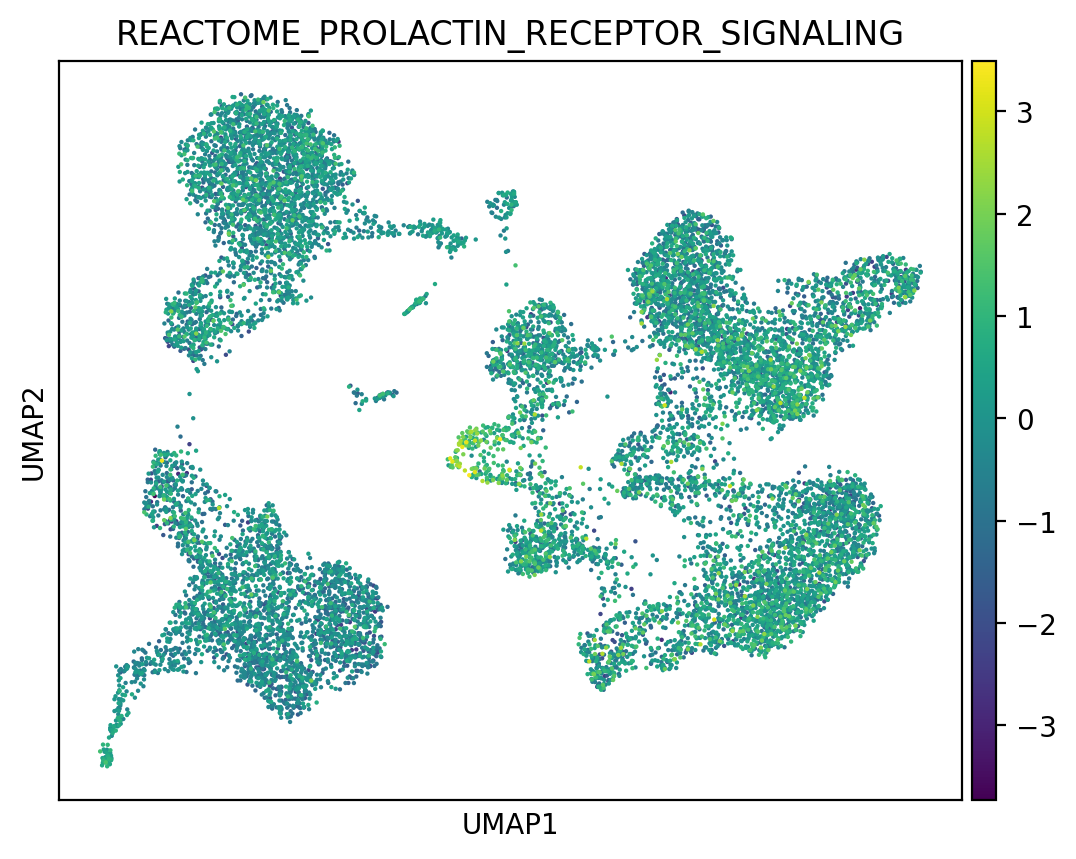

In [35]:
pathway_of_interest = "REACTOME_PROLACTIN_RECEPTOR_SIGNALING"

pathways = PBMC_lupus.uns["_vega"]["gmv_names"] 
pw_activities = PBMC_lupus.obsm["latent_embedding"] 

PBMC_lupus.obs[pathway_of_interest] =  PBMC_lupus.obsm["latent_embedding"][:,pathways.index(pathway_of_interest)]
sc.pl.umap(PBMC_lupus, color=[pathway_of_interest], size=10, ncols = 1, save="_REACTOME_PROLACTIN_RECEPTOR_SIGNALING.png")

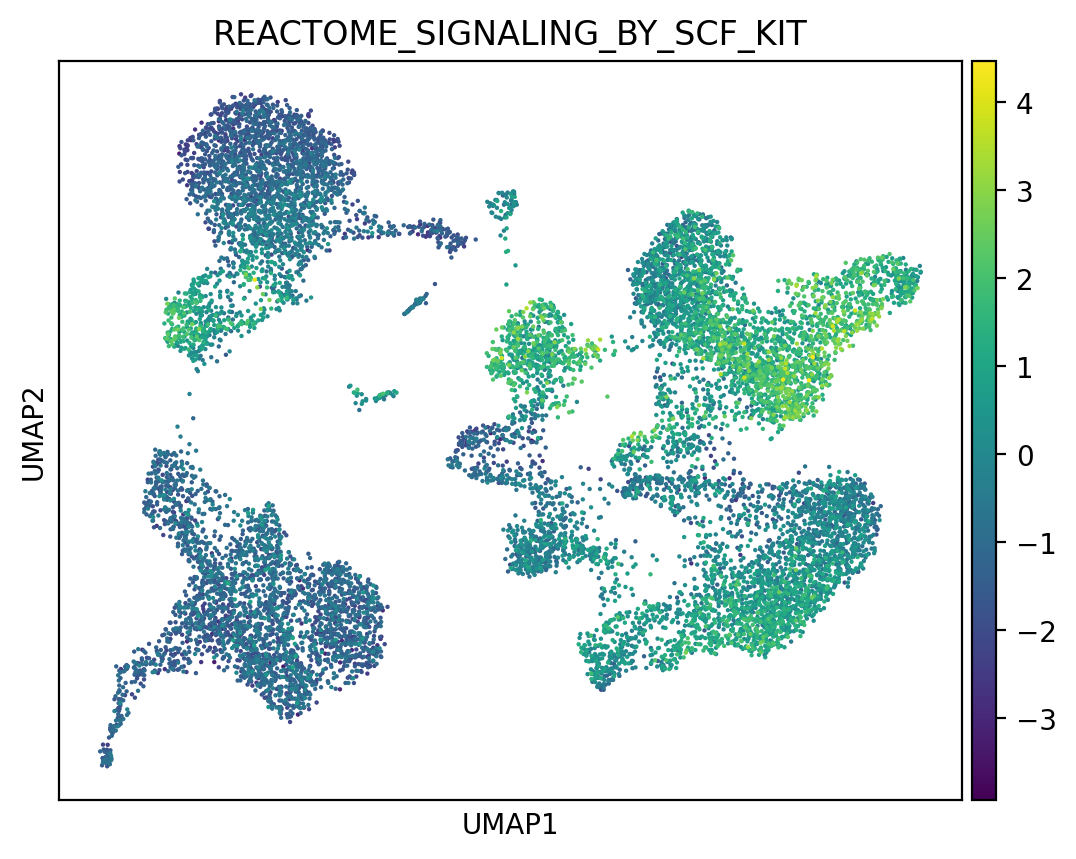

In [36]:
pathway_of_interest = "REACTOME_SIGNALING_BY_SCF_KIT"

pathways = PBMC_lupus.uns["_vega"]["gmv_names"] 
pw_activities = PBMC_lupus.obsm["latent_embedding"] 

PBMC_lupus.obs[pathway_of_interest] =  PBMC_lupus.obsm["latent_embedding"][:,pathways.index(pathway_of_interest)]
sc.pl.umap(PBMC_lupus, color=[pathway_of_interest], size=10, ncols = 1, save="_REACTOME_SIGNALING_BY_SCF_KIT.png")

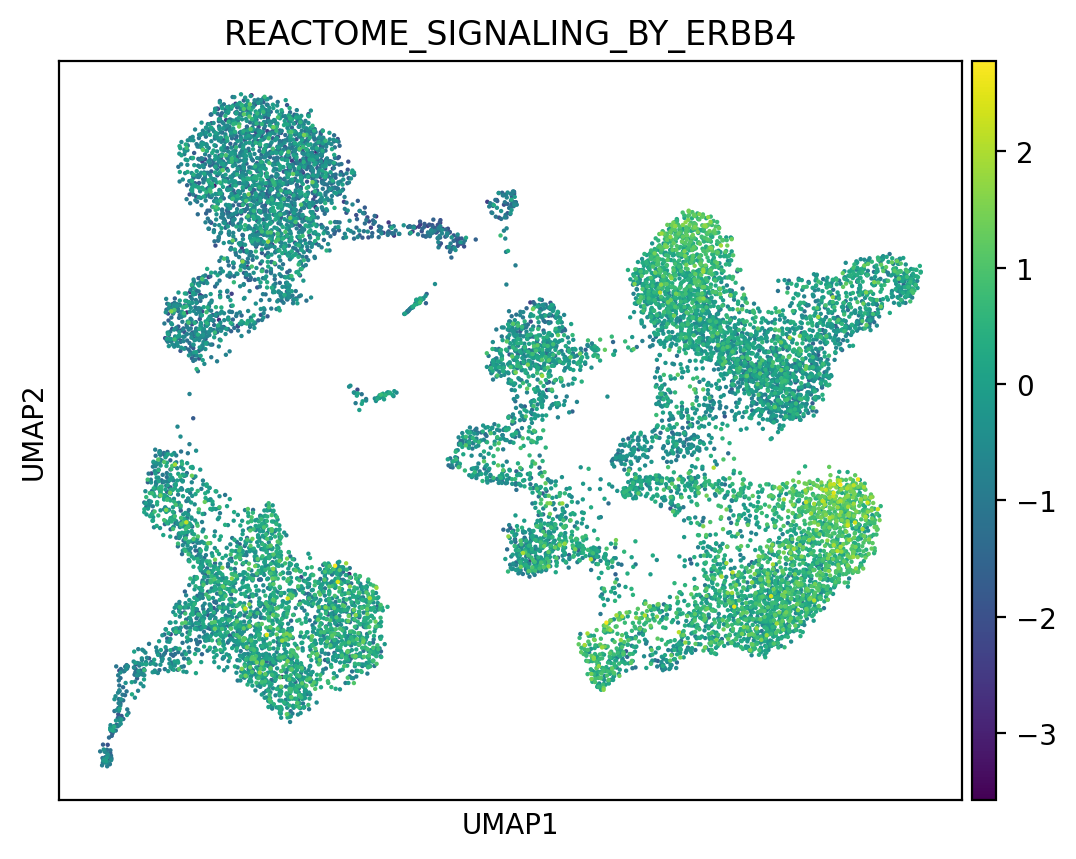

In [37]:
pathway_of_interest = "REACTOME_SIGNALING_BY_ERBB4"

pathways = PBMC_lupus.uns["_vega"]["gmv_names"] 
pw_activities = PBMC_lupus.obsm["latent_embedding"] 

PBMC_lupus.obs[pathway_of_interest] =  PBMC_lupus.obsm["latent_embedding"][:,pathways.index(pathway_of_interest)]
sc.pl.umap(PBMC_lupus, color=[pathway_of_interest], size=10, ncols = 1, save="_REACTOME_SIGNALING_BY_ERBB4.png")

In [ ]:
def plot_ranked_gene_weights(model: VEGA, adata,
                        gmv,
                        n_genes: int = 10):

    w = vega.state_dict()["decoder.sparse_layer.0.weight"].to("cpu")
    gmv_names = list(adata.uns['_vega']['gmv_names'])
    gene_names = adata.var.index.tolist()


    # Get values
    i = gmv_names.index(gmv)
    w_i = w[:,i].detach().numpy()
    sort_idx = np.argsort(w_i)[::-1]
    sort_w = w_i[sort_idx][:n_genes]
    genes = np.array(gene_names)[sort_idx][:n_genes]

    # Set plot params
    ymin = np.min(sort_w)
    ymax = np.max(sort_w)
    ymax += 0.3*(ymax - ymin)

    # Plot
    for ig, gene_name in enumerate(genes):
        plt.text(
            ig,
            sort_w[ig],
            gene_name,
            rotation='vertical',
            verticalalignment='bottom',
            horizontalalignment='center',
            color="black"
        )
    plt.title(gmv)
    plt.ylim(ymin, ymax)
    plt.xlim(-0.9, n_genes - 0.1)
    plt.xlabel('Ranking')
    plt.ylabel('Weight magnitude')
    plt.xticks(np.arange(0, n_genes, step=1), labels = np.arange(1, n_genes+1, step=1))

    plt.show()

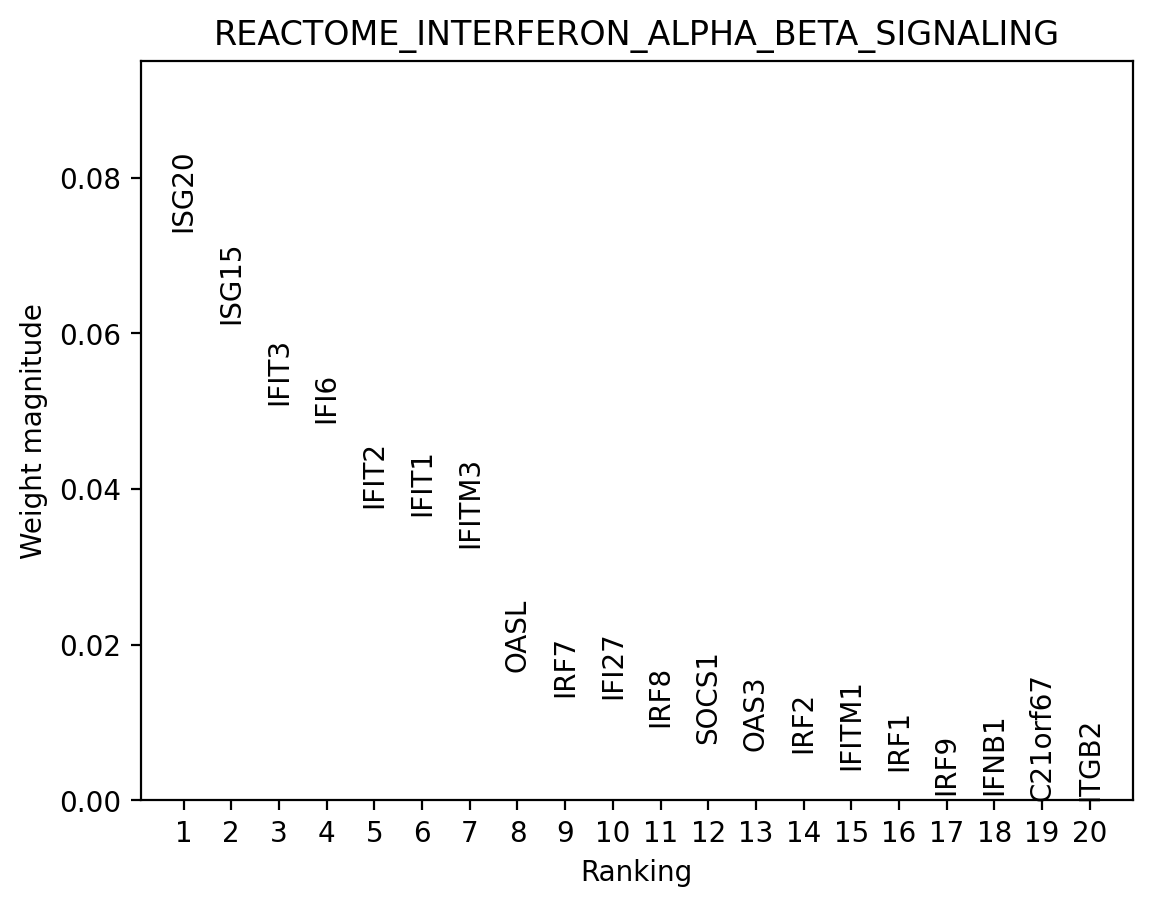

<Figure size 1280x960 with 0 Axes>

In [41]:
plot_ranked_gene_weights(vega, gmv= "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING", adata = PBMC_lupus, n_genes = 20)

plt.savefig("figures/gene_weights_REACTOME_INTERFERON_ALPHA_BETA_SIGNALING.png", dpi=300, bbox_inches='tight')

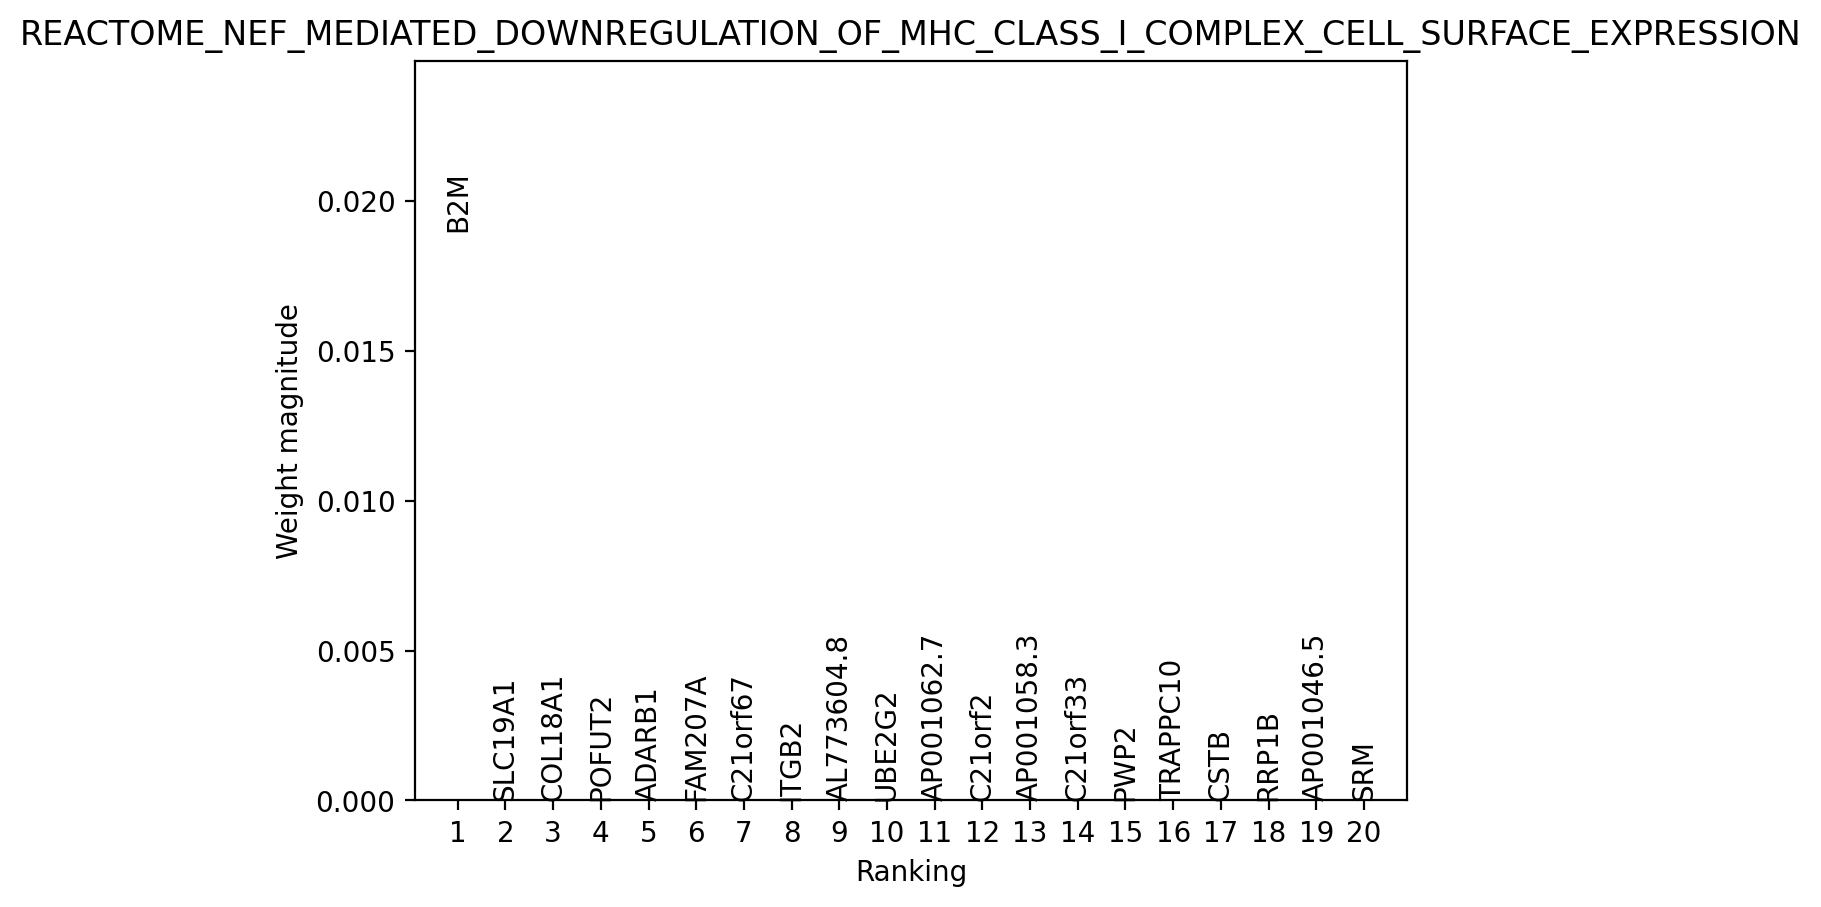

<Figure size 1280x960 with 0 Axes>

In [42]:
plot_ranked_gene_weights(vega, gmv= "REACTOME_NEF_MEDIATED_DOWNREGULATION_OF_MHC_CLASS_I_COMPLEX_CELL_SURFACE_EXPRESSION", adata = PBMC_lupus, n_genes = 20)

plt.savefig("figures/gene_weights_REACTOME_NEF_MEDIATED_DOWNREGULATION_OF_MHC_CLASS_I_COMPLEX_CELL_SURFACE_EXPRESSION.png", dpi=300, bbox_inches='tight')

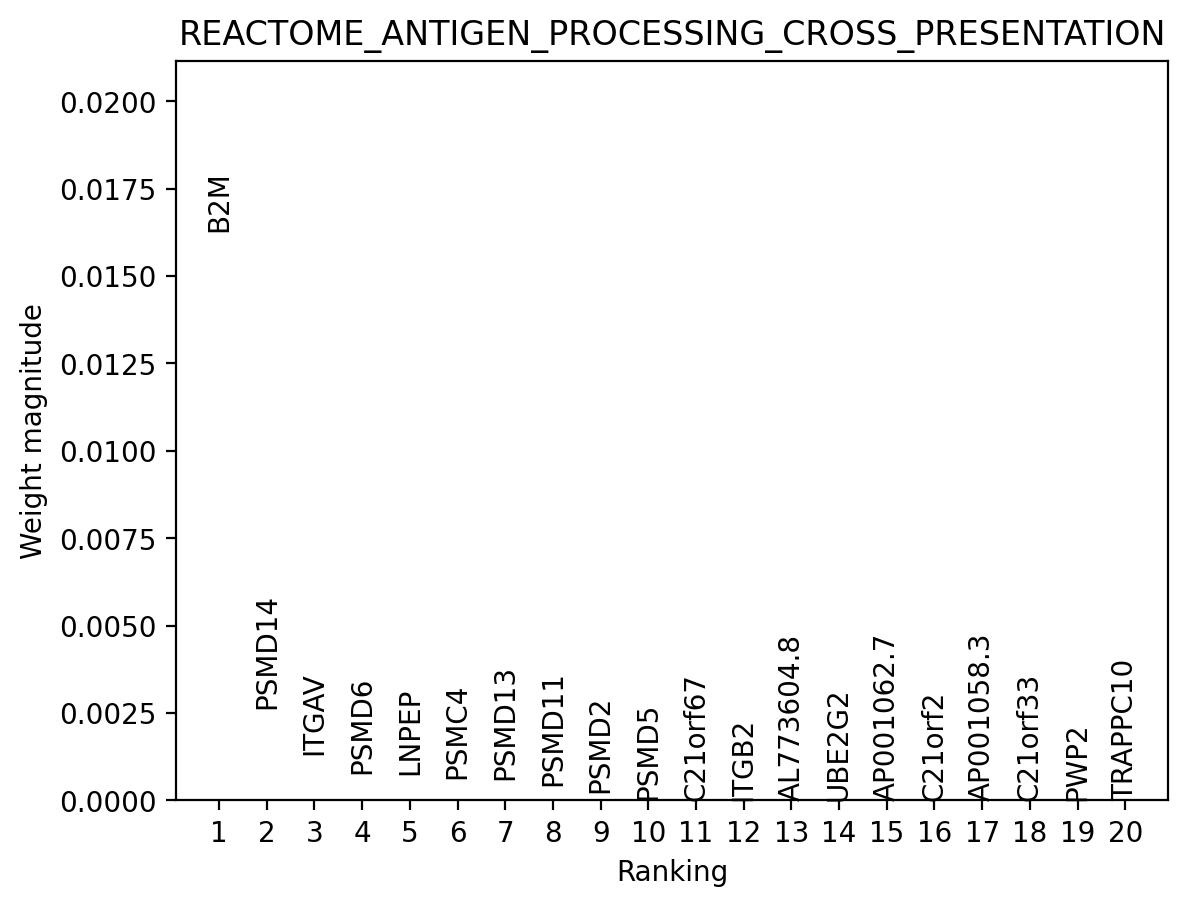

<Figure size 1280x960 with 0 Axes>

In [43]:
plot_ranked_gene_weights(vega, gmv= "REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION", adata = PBMC_lupus, n_genes = 20)

plt.savefig("figures/gene_weights_REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION.png", dpi=300, bbox_inches='tight')

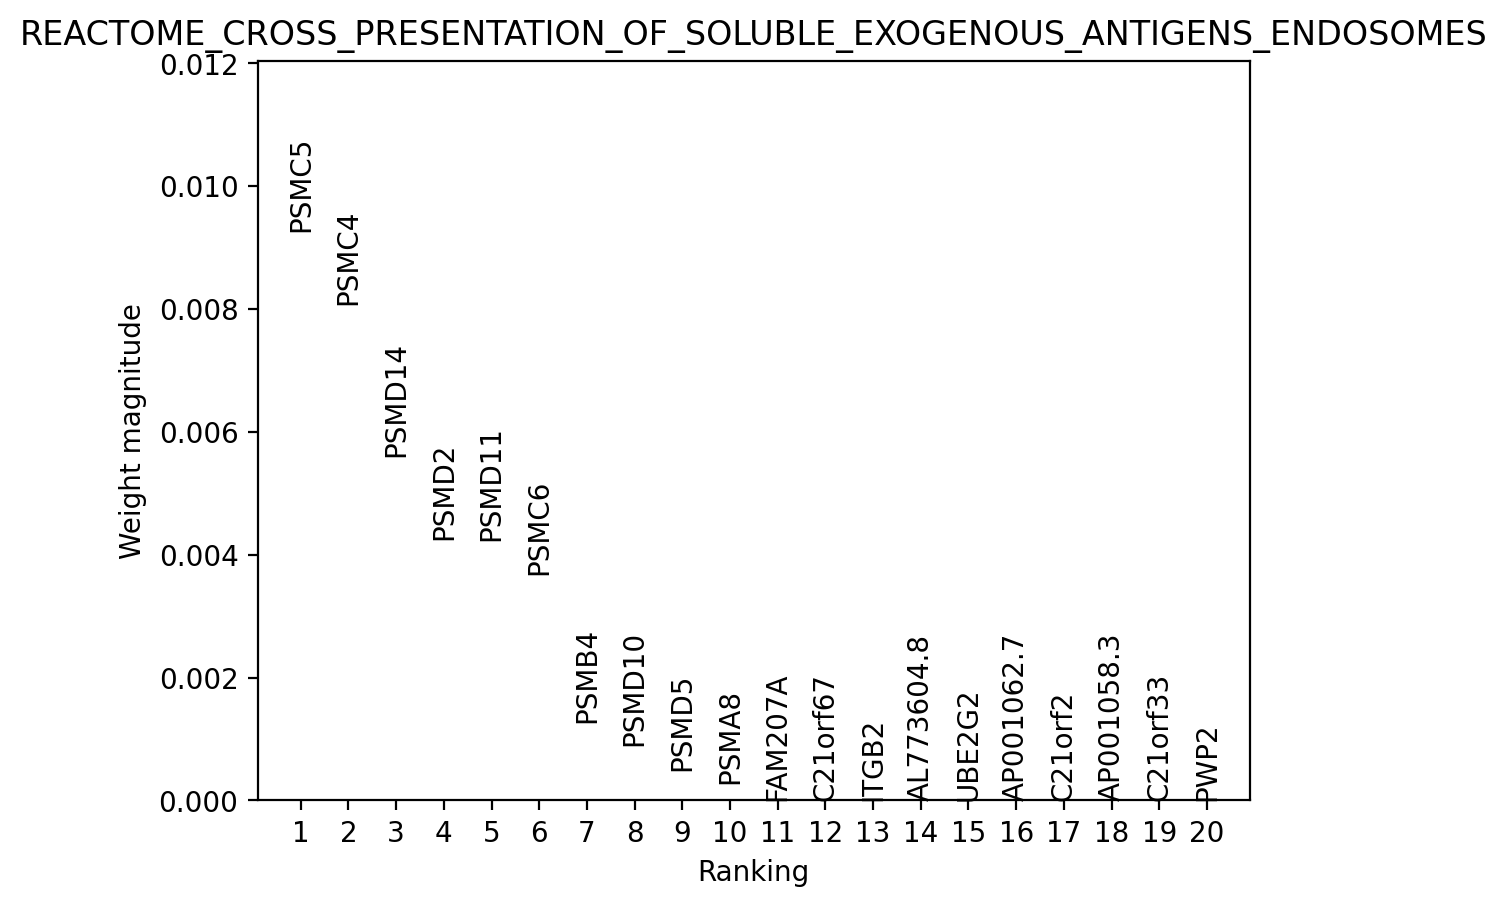

<Figure size 1280x960 with 0 Axes>

In [44]:
plot_ranked_gene_weights(vega, gmv= "REACTOME_CROSS_PRESENTATION_OF_SOLUBLE_EXOGENOUS_ANTIGENS_ENDOSOMES", adata = PBMC_lupus, n_genes = 20)

plt.savefig("figures/gene_weights_REACTOME_CROSS_PRESENTATION_OF_SOLUBLE_EXOGENOUS_ANTIGENS_ENDOSOMES.png", dpi=300, bbox_inches='tight')

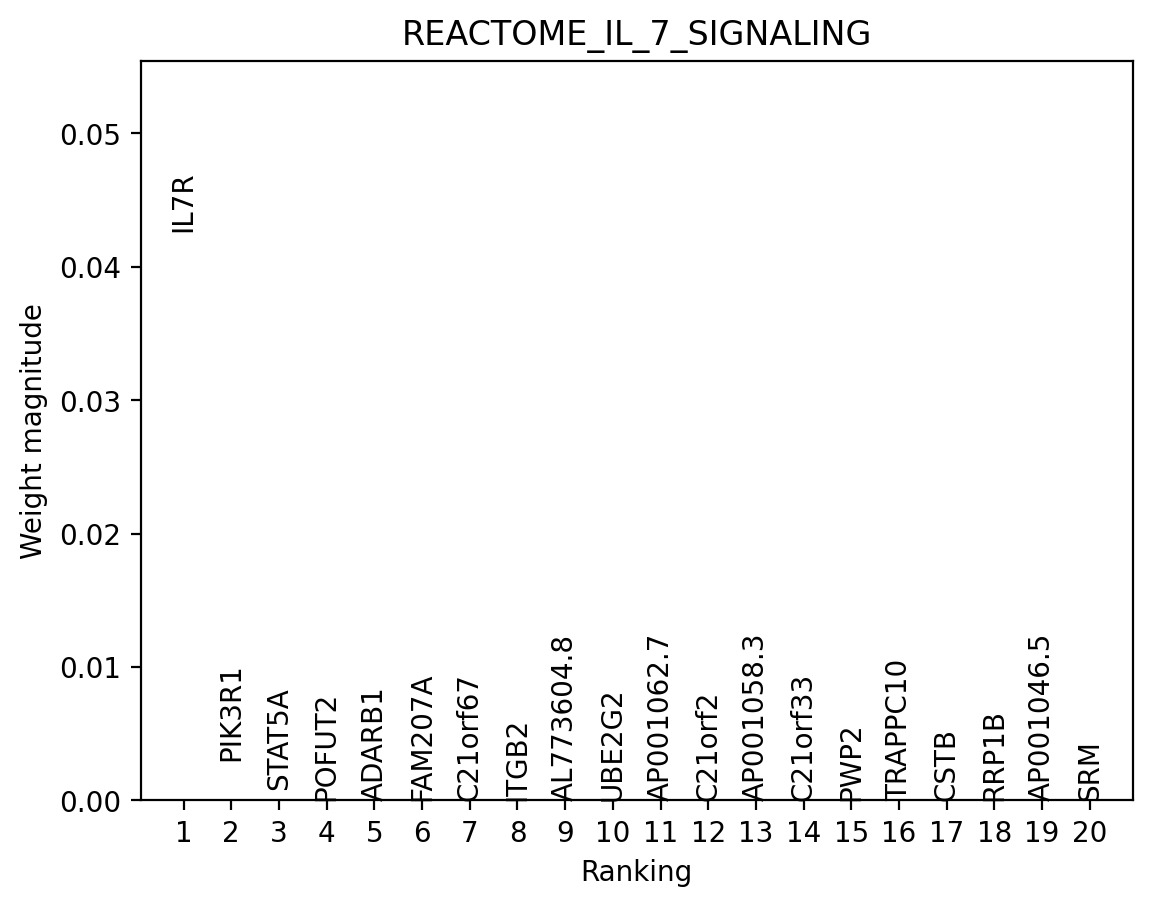

<Figure size 1280x960 with 0 Axes>

In [45]:
plot_ranked_gene_weights(vega, gmv= "REACTOME_IL_7_SIGNALING", adata = PBMC_lupus, n_genes = 20)

plt.savefig("figures/gene_weights_REACTOME_IL_7_SIGNALING.png", dpi=300, bbox_inches='tight')

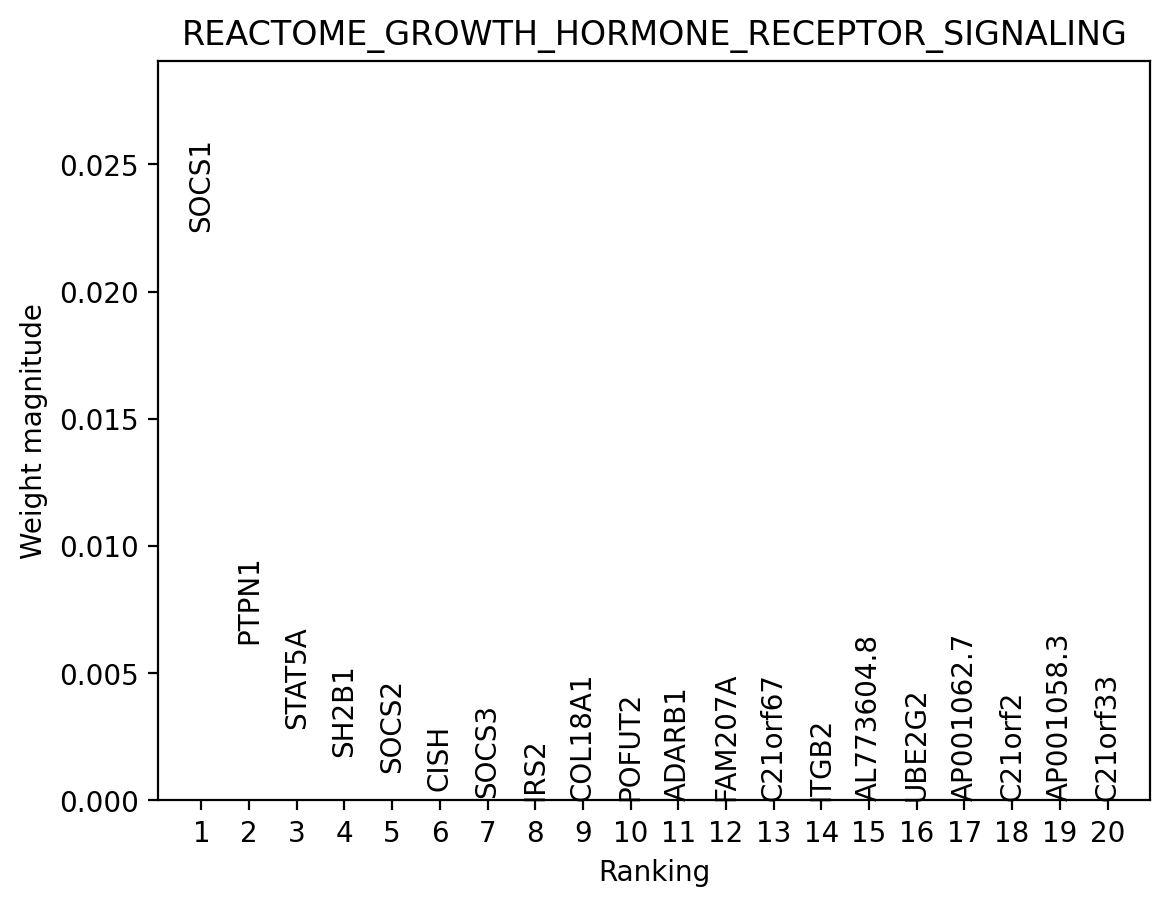

<Figure size 1280x960 with 0 Axes>

In [46]:
plot_ranked_gene_weights(vega, gmv= "REACTOME_GROWTH_HORMONE_RECEPTOR_SIGNALING", adata = PBMC_lupus, n_genes = 20)

plt.savefig("figures/gene_weights_REACTOME_GROWTH_HORMONE_RECEPTOR_SIGNALING.png", dpi=300, bbox_inches='tight')

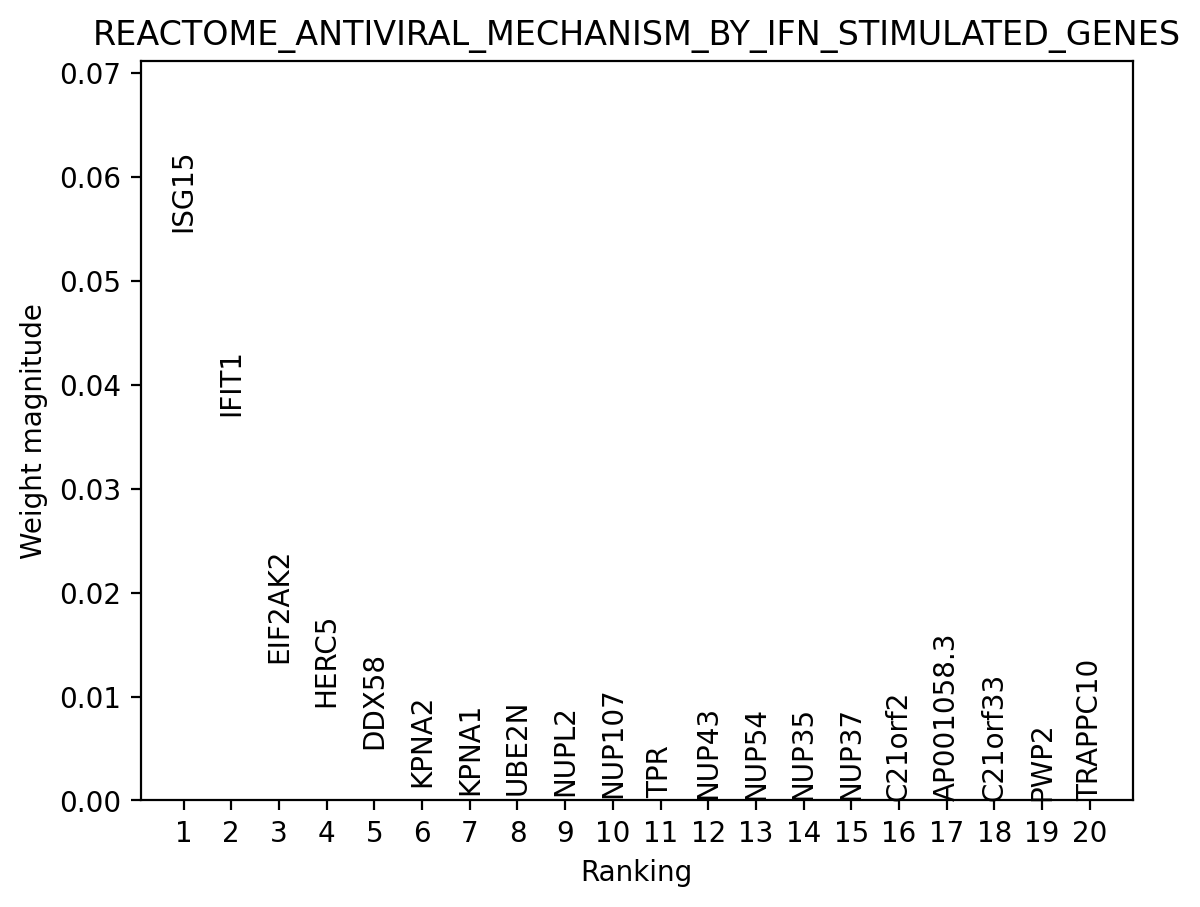

<Figure size 1280x960 with 0 Axes>

In [47]:
plot_ranked_gene_weights(vega, gmv= "REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED_GENES", adata = PBMC_lupus, n_genes = 20)

plt.savefig("figures/gene_weights_REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED_GENES.png", dpi=300, bbox_inches='tight')

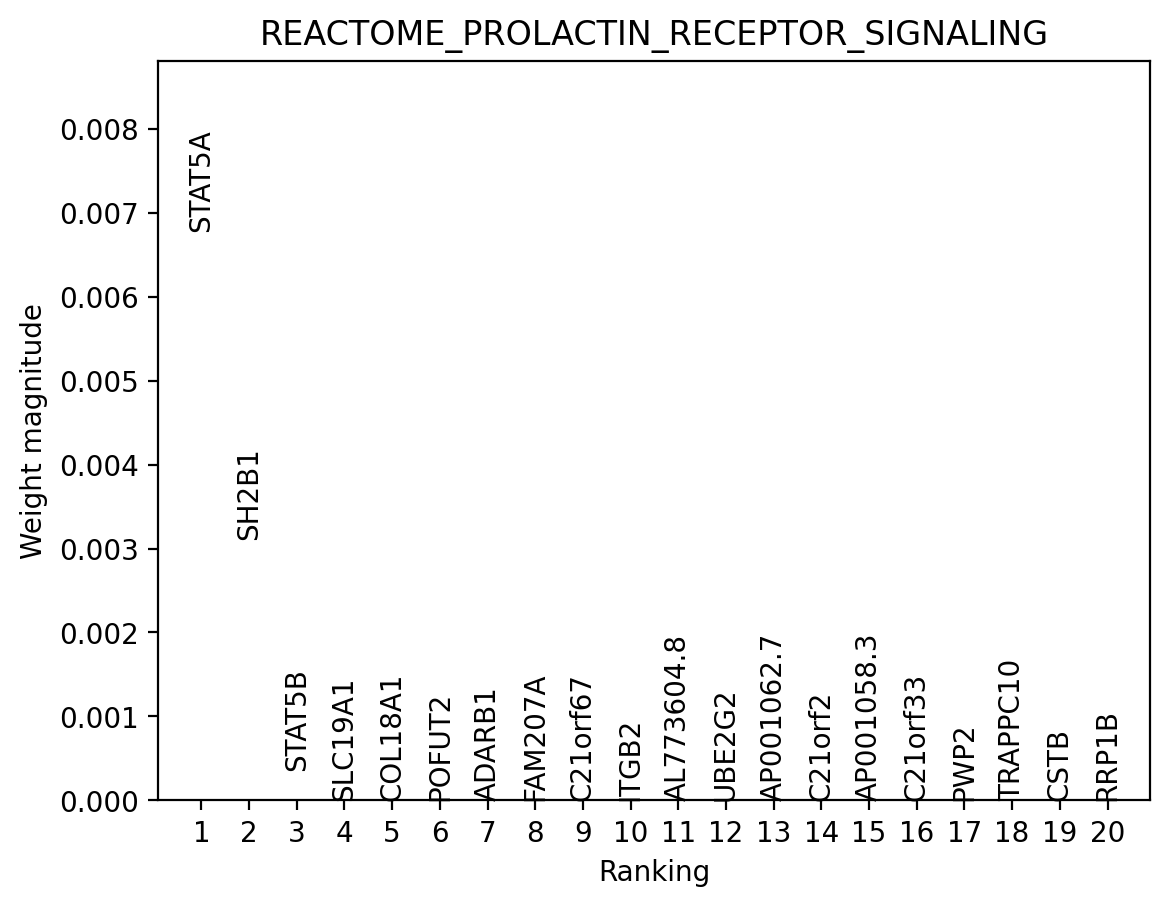

<Figure size 1280x960 with 0 Axes>

In [48]:
plot_ranked_gene_weights(vega, gmv= "REACTOME_PROLACTIN_RECEPTOR_SIGNALING", adata = PBMC_lupus, n_genes = 20)

plt.savefig("figures/gene_weights_REACTOME_PROLACTIN_RECEPTOR_SIGNALING.png", dpi=300, bbox_inches='tight')

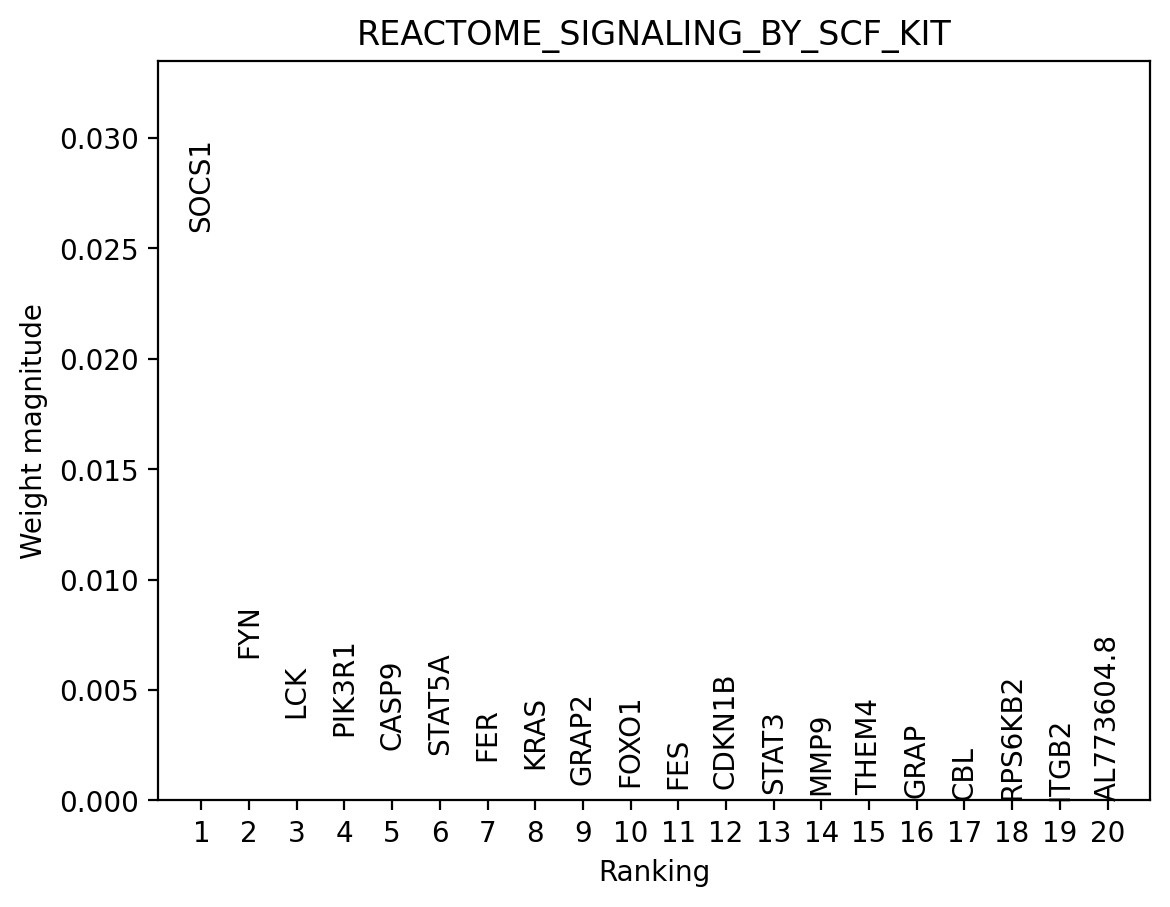

<Figure size 1280x960 with 0 Axes>

In [49]:
plot_ranked_gene_weights(vega, gmv= "REACTOME_SIGNALING_BY_SCF_KIT", adata = PBMC_lupus, n_genes = 20)

plt.savefig("figures/gene_weights_REACTOME_SIGNALING_BY_SCF_KIT.png", dpi=300, bbox_inches='tight')

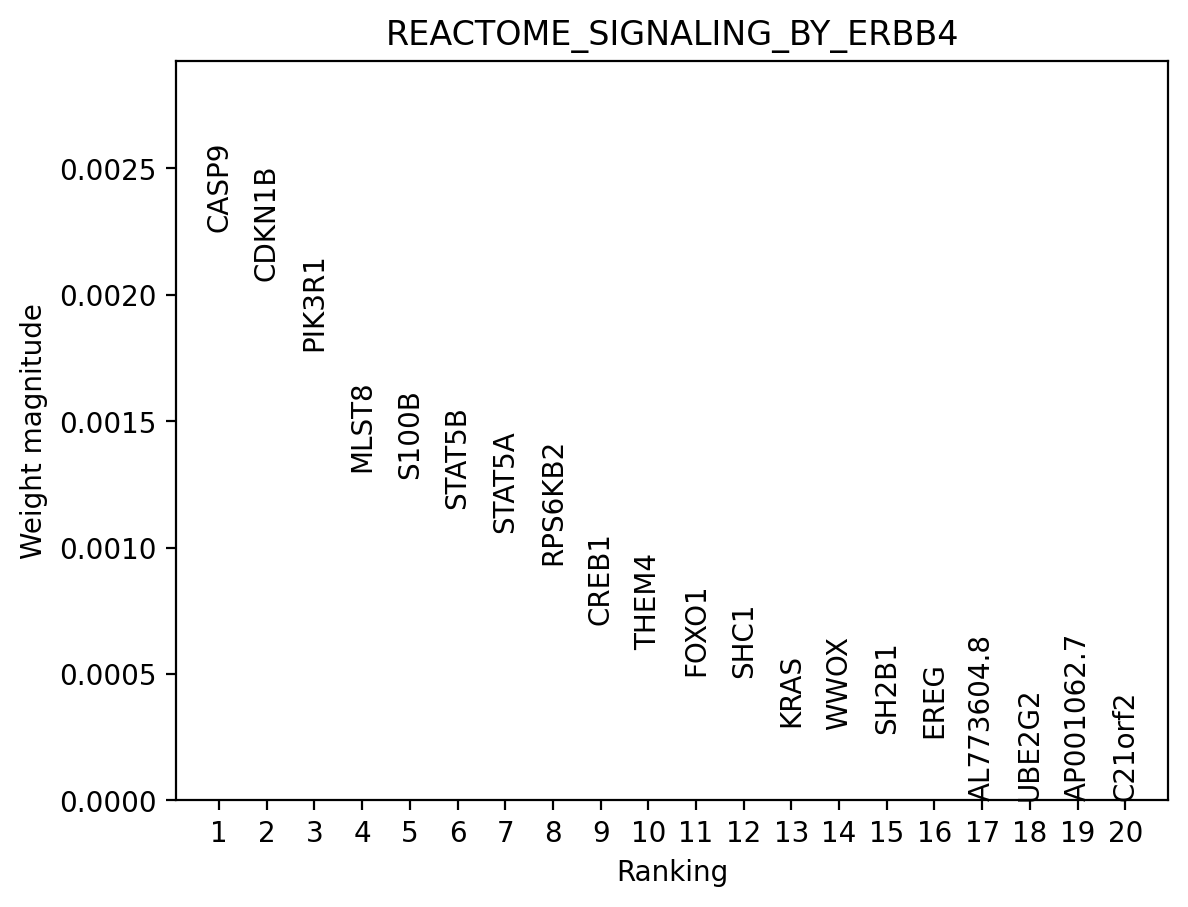

<Figure size 1280x960 with 0 Axes>

In [50]:
plot_ranked_gene_weights(vega, gmv= "REACTOME_SIGNALING_BY_ERBB4", adata = PBMC_lupus, n_genes = 20)

plt.savefig("figures/gene_weights_REACTOME_SIGNALING_BY_ERBB4.png", dpi=300, bbox_inches='tight')